# Applied Time Series Analysis - Lab - Block 1 
Name: Rini Gupta 

  Date: 3/2/21
***


#Introduction

---
The purpose of this lab was to further investigate the relationship between El Nino events and natural disasters, specifically the impact of these natural disasters on humans across the globe. I use the same datasets in the original published paper to try to replicate the results of the authors and expand upon the analysis with statistical analysis (autocorrelation, periodogram, frequency domain analysis). The scope of this lab was a global analysis, most granually on a country level basis, using two indices of El Nino strength and UN numbers pertaining to population sizes and number of people affected by a natural disaster. The time span of this analysis is 1964-2017, but in some cases the datasets extended past this window and were analyzed in their full breadth. This lab synthesized skills of time domain analysis, frequency domain analysis, and plotting data using R. 


###Objectives
> The objective of this study was to establish the correlation between two indicators of El Nino Southern Oscillation (ENSO) events from 1964-2017 and people affected by natural disasters (PAD) on a global, regional, and country-level scale. This study aimed to understand the connection between predictable ENSO events and natural disasters (distinct from technological disasters) because there are a variety of public health consequences during periods of climatic variation relating to nutrition, injuries, mental health, and diseases. By gaining a better understanding of the correlation, if any exists, between ENSO events and PAD, the results of this study can better inform disaster prevention efforts.



###Methods

> The authors of this study utilized linear regression techniques in order to assess the correlation between two indicators of ENSO activity, the multivariate El Nino Index (MEI) and ONI (Oceanic Nino Index)  and the PAD rate. In order to focus the analysis, the authors chose to study three regions and three disaster types more in depth. The three regions analyzed were South Asia, East Asia, and Southeast Asia and the three disaster types were floods, droughts, and storms. The PAD data for analysis was sourced from the EM-DAT database which compiled data from various sources such as the United Nations and governmental/non-governmental agencies if a specific set of criteria was met. ENSO index data came from the National Oceanic and Atmospheric Administration (NOAA). The models used to regress the data were Poisson Generalized Additive Models (GAMs) and distributed-lag non-linear models. 
 
###Results 
> Out of all natural disasters, the authors found that 95% of those affected by disaster were affected by either floods, droughts, or storms. The authors discovered that flood events are the most directly related to El Nino. Most of the people affected by these natural disasters live in Asia. Specifically, India had the highest increase in PAD following the onset of an El Nino event. The connections between these natural disasters and the onset of El Nino suggest a positive correlation between ENSO events and PAD numbers on a global level. The duration of time that the impacts of an El Nino year lasted could range from just one year to two years after the onset of an El Nino event. 


The packages used for this lab are below:


```R
install.packages("tswge")
library("twsge")
```



#Methods

Below, I install the textbook's package called "twsge" to use in later code blocks.

In [ ]:
# Install required packages
install.packages("tswge")
library("tswge")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



#### Dataset Information

I use five separate datasets below in order to complete the analysis for this lab. They are linked in each of their respective sections.

1. Oceanic Nino Index (ONI)
2. Multivariate ENSO Index (MEI)
3. People Affected by Natural Disasters (PAD)
4. World Bank Population Data
5. India Annual Precipitation Data

*NOTE: Most of the preprocessing code for the ONI and MEI datasets comes from the code snippet provided to us by Prof. Davis.

## Section 1: Loading and Processing the Data Into Time Series 
The two datasets for the ENSO indexes are linked below. I had to select the appropriate time frame in later code blocks.

1. Oceanic Ni&ntilde;o Index (ONI)
    - https://psl.noaa.gov/data/correlation/oni.data
    - https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt 
1. Multi-variate ENSO Index (MEI)
    - https://psl.noaa.gov/enso/mei/data/meiv2.data (1979-2021)
    - https://psl.noaa.gov/enso/mei.old/table.html (1950-2018)

### Oceanic Ni&ntilde;o Index (ONI)

In [ ]:
# Define the URL, scrub the file name from the URL and download to /tmp
oni.url <- "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
oni.name <- tail(unlist(strsplit(oni.url, "/")), n=1)
oni.file <- paste("/tmp/", oni.name, sep="")
download.file(oni.url, oni.file, method = 'auto')
oni.name

[1] "oni.ascii.txt"

Examining the ONI dataset and we see that it is organized as:

```
SEAS YR TOTAL ANOM
AAA DDDD DD.DD +D.DD
```


In [ ]:
# Read directly to dataframe preserving the header
oni.df <- read.table(oni.file, header = TRUE)
head(oni.df)

,SEAS,YR,TOTAL,ANOM
,<chr>,<int>,<dbl>,<dbl>
1,DJF,1950,24.72,-1.53
2,JFM,1950,25.17,-1.34
3,FMA,1950,25.75,-1.16
4,MAM,1950,26.12,-1.18
5,AMJ,1950,26.32,-1.07
6,MJJ,1950,26.31,-0.85


I filtered the data based on the desired time frame (1964-2017) and the desired month (DJF) to plot the anomolies and replicate the ONI subplot in figure 1. Throughout this notebook, I use the variable filter in order to subset my dataframes rather than the subset function so I can clearly see what conditions I am filtering on. 

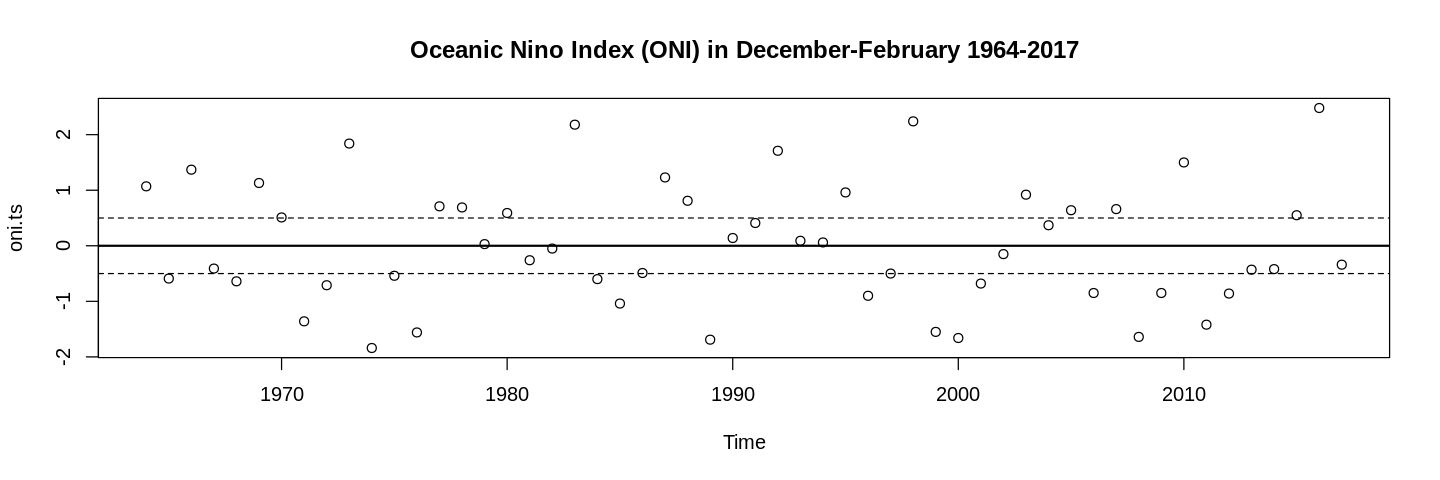

In [ ]:
# Turn anomalies into a time series object
filter <- oni.df$SEAS == 'DJF' & oni.df$YR > 1963 & oni.df$YR < 2018
oni.data.points <- oni.df[filter,]$ANOM
oni.ts <- ts(oni.data.points, start = c(1964, 1), frequency = 1)
options(repr.plot.width = 12, repr.plot.height = 4)
plot(oni.ts, main = "Oceanic Nino Index (ONI) in December-February 1964-2017", type = 'p')
abline(h = 0.5, lty = 2)
abline(h = 0, lwd = 1.75)
abline(h = -0.5, lty = 2)

### Multi-variate ENSO Index (MEI)
The MEI data (1950-2018) is organized in an HTML file, so the code below converts the data into a format we can use (Code Snippet).

In [ ]:
# Define the URL, scrub the file name, and download it to /tmp
mei.url <- "https://psl.noaa.gov/enso/mei.old/table.html"
mei.name <- tail(unlist(strsplit(mei.url, "/")), n=1)
mei.file <- paste("/tmp/", mei.name, sep="")
download.file(mei.url, mei.file, method = 'auto')

The column information is on a line that starts with YEAR. There are not any other rows that would cause issues since there is only one that begins with YEAR. Using the grep function and regular expressions, I scrape the data of interest (Code Snippet).



In [ ]:
# Read the column names from the data
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^YEAR.*", my.line)
  if (length(a) > 0) {
    my.cols <- unlist(strsplit(my.line, "\\s+"))
  }
}

The code below creates a dataframe with the appropriate column names.

In [ ]:
# Create an empty dataframe
n.cols <- length(my.cols)
mei.df <- data.frame(matrix(ncol = n.cols, nrow = 0))
colnames(mei.df) <- my.cols 
str(mei.df)

'data.frame':	0 obs. of  13 variables:
 $ YEAR  : logi 
 $ DECJAN: logi 
 $ JANFEB: logi 
 $ FEBMAR: logi 
 $ MARAPR: logi 
 $ APRMAY: logi 
 $ MAYJUN: logi 
 $ JUNJUL: logi 
 $ JULAUG: logi 
 $ AUGSEP: logi 
 $ SEPOCT: logi 
 $ OCTNOV: logi 
 $ NOVDEC: logi 


Prof. Davis used the grep function in his code snippet below to extract the desired data and added it into the dataframe.

In [ ]:
# Get all the data lines
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^[0-9].*", my.line)
  if (length(a) > 0) {
    my.data <- unlist(strsplit(my.line, "\\s+"))
    num.data <- length(my.data)
    if (num.data == n.cols) {
      my.values <- c()
      for (d in my.data) {
        my.values <- append(my.values, as.numeric(d))
      }
      mei.df[nrow(mei.df)+1,] = my.values
    }
  }
}

Creating the final dataframe below using slicing.

In [ ]:
# Slice the dataframe for all rows and not the first column
mei.df[1:10, 2:n.cols]

,DECJAN,JANFEB,FEBMAR,MARAPR,APRMAY,MAYJUN,JUNJUL,JULAUG,AUGSEP,SEPOCT,OCTNOV,NOVDEC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.030,-1.133,-1.283,-1.071,-1.434,-1.412,-1.269,-1.042,-0.631,-0.441,-1.151,-1.235
2,-1.049,-1.152,-1.178,-0.511,-0.374,0.288,0.679,0.818,0.726,0.720,0.694,0.504
3,0.433,0.138,0.071,0.224,-0.307,-0.756,-0.305,-0.374,0.310,0.265,-0.351,-0.098
4,0.044,0.401,0.277,0.687,0.756,0.191,0.382,0.209,0.483,0.087,0.078,0.351
5,-0.036,-0.027,0.154,-0.616,-1.465,-1.558,-1.355,-1.456,-1.159,-1.335,-1.124,-1.088
6,-0.740,-0.669,-1.117,-1.621,-1.653,-2.247,-1.976,-2.050,-1.829,-1.738,-1.821,-1.846
7,-1.408,-1.275,-1.371,-1.216,-1.304,-1.523,-1.244,-1.118,-1.350,-1.478,-1.024,-0.993
8,-0.915,-0.348,0.108,0.383,0.813,0.730,0.926,1.132,1.117,1.068,1.138,1.268
9,1.473,1.454,1.313,0.991,0.673,0.812,0.700,0.421,0.171,0.203,0.476,0.691


Below, I create a filter in order to get the appropriate time range for the appropriate month. I then replot the MEI subplot shown in Fig. 1 and add horizontal lines in at 0, -0.5, and 0.5 to replicate the plot.

In [ ]:
filter <- mei.df$YEAR > 1963 & mei.df$YEAR < 2018
mei.data.points <- mei.df[filter, 'DECJAN']

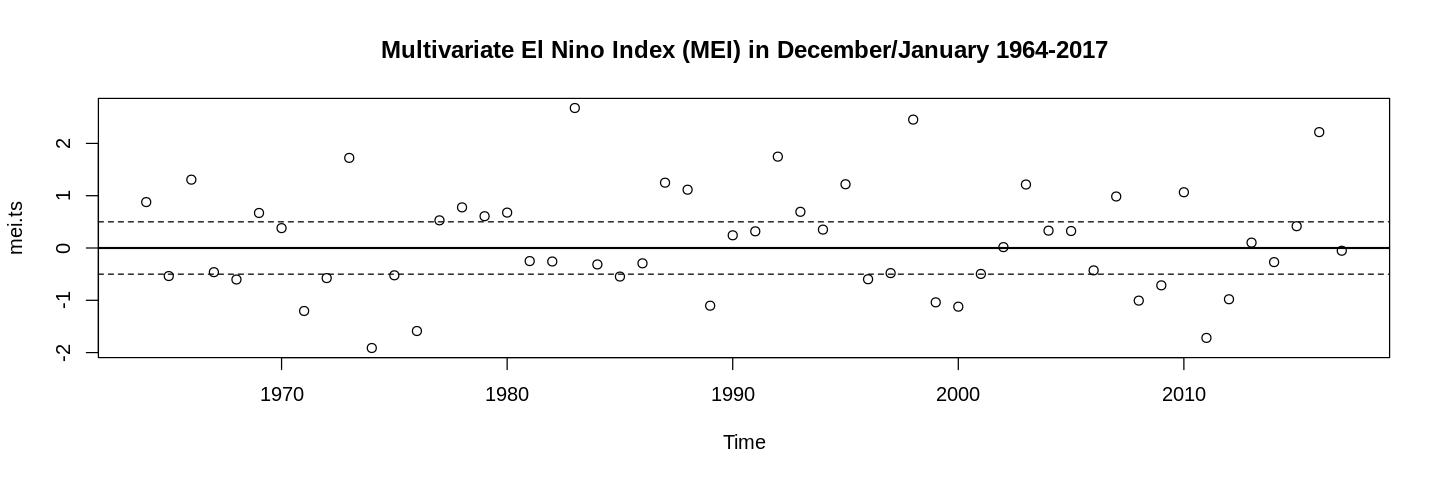

In [ ]:
mei.ts <- ts(mei.data.points, start = c(1964, 1), frequency = 1)
plot(mei.ts, main = "Multivariate El Nino Index (MEI) in December/January 1964-2017", type = 'p')
abline(h = 0.5, lty = 2)
abline(h = 0, lwd = 1.75)
abline(h = -0.5, lty = 2)

### People Affected by Disasters (PAD) Data:

####Reading in the data
The data for this section is sourced from https://public.emdat.be/data. I created a free account to download the data, checked all regions, filtered the timeframe to be between 1964 and 2017, and then selected all disaster types except technological, complex, extra-terrestrial, and geophysical. 

The data was downloaded as an .xlxs file from the site linked above. At first, I imported a library called readxl in order to read in a .xlxs file format; however, I learned that excel can export data as a .csv file, so I changed the final format to be .csv in order to simplify code. The name of my .csv file is PAD.csv. 

I used the argument skip = 6 in order to get the correct column names for the PAD dataset since the first 6 lines of the .csv were extraneous text. 

In [ ]:
pad.df <- read.csv('PAD.csv', skip = 6) # Reading in the data

In [ ]:
colnames(pad.df) # Getting an idea of what the column names are 

[1] "Dis.No"                          "Year"                           
 [3] "Seq"                             "Disaster.Group"                 
 [5] "Disaster.Subgroup"               "Disaster.Type"                  
 [7] "Disaster.Subtype"                "Disaster.Subsubtype"            
 [9] "Event.Name"                      "Entry.Criteria"                 
[11] "Country"                         "ISO"                            
[13] "Region"                          "Continent"                      
[15] "Location"                        "Origin"                         
[17] "Associated.Dis"                  "Associated.Dis2"                
[19] "OFDA.Response"                   "Appeal"                         
[21] "Declaration"                     "Aid.Contribution"               
[23] "Dis.Mag.Value"                   "Dis.Mag.Scale"                  
[25] "Latitude"                        "Longitude"                      
[27] "Local.Time"                      "River.Basin"                    
[29] "Start.Year"                      "Start.Month"                    
[31] "Start.Day"                       "End.Year"                       
[33] "End.Month"                       "End.Day"                        
[35] "Total.Deaths"                    "No.Injured"                     
[37] "No.Affected"                     "No.Homeless"                    
[39] "Total.Affected"                  "Reconstruction.Costs...000.US.."
[41] "Insured.Damages...000.US.."      "Total.Damages...000.US.."       
[43] "CPI"

#### Population totals for countries
The total populations for countries can be found through [The World Bank](https://data.worldbank.org/indicator/SP.POP.TOTL).


In [ ]:
wbank.url <- "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"
wbank.name <- "world_bank.zip"
wbank.file <- paste("/tmp/", wbank.name, sep="")
download.file(wbank.url, wbank.file)

These data are downloaded as a zip file.
We can extract zip files in R using [`unzip`](https://www.rdocumentation.org/packages/utils/versions/3.6.2/topics/unzip).

In [ ]:
unzip(zipfile = wbank.file, exdir = "/tmp")

In [ ]:
my.file <- ""
for (tmp.file in list.files("/tmp")){
  a <- grep("^API_SP.POP.TOTL.*csv", tmp.file)
  if (length(a) > 0) {
    my.file <- tmp.file
  }
}
print(my.file)

[1] "API_SP.POP.TOTL_DS2_en_csv_v2_2106202.csv"


In [ ]:
# Add the path back to the file name
wb.file <- paste("/tmp/", my.file, sep="")

In [ ]:
wb.df <- read.csv(wb.file, header = TRUE, skip = 4)

In [ ]:
head(wb.df)

,Country.Name,Country.Code,Indicator.Name,Indicator.Code,X1960,X1961,X1962,X1963,X1964,X1965,⋯,X2012,X2013,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
1,Aruba,ABW,"Population, total",SP.POP.TOTL,54211,55438,56225,56695,57032,57360,⋯,102560,103159,103774,104341,104872,105366,105845,106314,NA,NA
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973,9169410,9351441,9543205,9744781,9956320,⋯,31161376,32269589,33370794,34413603,35383128,36296400,37172386,38041754,NA,NA
3,Angola,AGO,"Population, total",SP.POP.TOTL,5454933,5531472,5608539,5679458,5735044,5770570,⋯,25107931,26015780,26941779,27884381,28842484,29816748,30809762,31825295,NA,NA
4,Albania,ALB,"Population, total",SP.POP.TOTL,1608800,1659800,1711319,1762621,1814135,1864791,⋯,2900401,2895092,2889104,2880703,2876101,2873457,2866376,2854191,NA,NA
5,Andorra,AND,"Population, total",SP.POP.TOTL,13411,14375,15370,16412,17469,18549,⋯,82427,80774,79213,78011,77297,77001,77006,77142,NA,NA
6,Arab World,ARB,"Population, total",SP.POP.TOTL,92197753,94724510,97334442,100034179,102832760,105736431,⋯,371443547,379705717,387907747,396028278,404024435,411898967,419790591,427870270,NA,NA


####Getting an idea about which population data is available
In the code block below, I check to see what countries are missing population data and for which year in order to gain an understanding of where missing data exists for later processing. I modified the code from Prof. Davis to just see which countries are missing in which years. 

In [ ]:
for (i in 1:nrow(pad.df)) {
    tmp.iso <- pad.df[i, ][['ISO']]
    tmp.iso <- pad.df[i, ][['ISO']]
    tmp.year <- pad.df[i, ][['Start Year']]
    tmp.col <- paste("X", tmp.year, sep="")
    # Match returns "NA" if no match
    a <- match(tmp.iso, wb.df$Country.Code)
    if (!is.na(a)) {
      tmp.pop <- wb.df[,tmp.col][a]
      #print(c(tmp.iso, tmp.year, tmp.pop))
    }
    else {
      print(paste("Could not match", tmp.iso))
      print(paste("Could not match", tmp.year))
  }
}

In [ ]:
subset.pad.df = data.frame(pad.df$Start.Year, pad.df$ISO, pad.df$Total.Affected)
colnames(subset.pad.df)

[1] "pad.df.Start.Year"     "pad.df.ISO"            "pad.df.Total.Affected"

Get a list of all the unique years in order to aggregate by year later on. 

In [ ]:
unique.years = unique(pad.df$Start.Year)
unique.years

[1] 1964 1965 1966 1967 1968 1969 1972 1971 1970 1973 1974 1975 1976 1977 1978
[16] 1979 1983 1980 1982 1981 1984 1985 1986 1987 1988 1989 1990 1992 1991 1993
[31] 1994 1995 1996 1997 1998 1999 2001 2000 2002 2003 2004 2005 2006 2007 2008
[46] 2009 2010 2011 2012 2013 2014 2015 2016 2017

Below, I am creating two row filters to ensure I am getting the appropriate data out of the dataframe. Filter1 and filter2 show that there are indeed some missing values, so I made sure to use two conditions (the correct year and no missing data) in later code. 

In [ ]:
filter1 <- subset.pad.df$pad.df.Start.Year == 1964 & !is.na(subset.pad.df$pad.df.Total.Affected)
filter2 <- subset.pad.df$pad.df.Start.Year == 1964 

nrow(subset.pad.df[filter1,])
nrow(subset.pad.df[filter2,])

[1] 37

[1] 55

Here, I am testing to see how to get the appropriate population number for Afghanistan in 1961 before I write a more generalizable function. 

In [ ]:
filter = wb.df$Country.Code == 'AFG'
wb.df[filter, 'X1961']

[1] 9169410

#### Getting country populations for a specific year using the World Bank dataset

Because I will need to be able to access the population for a given country in a given year in order to perform later analysis, I decided to write a function in order to return the desired population value. The function was automatically returning an empty vector if there was missing data, so I added an additional function to return NA whenever there was missing population data. 

In [ ]:
isEmpty <- function(x) { # isEmpty function code is from Stack Overfrlow
    return(length(x)==0)
}

get_country_pop_for_year <- function(country.code, year) {
  # Method returns the country's population in a particular year or NA if there is missing population data
  # Inputs: character, country.code --> three letter country code
  #         integer, year --> year of desired population count
  # Output: int, population number or NA if there is missing data
  year_col <- paste("X", year, sep="")
  filter <-  wb.df$Country.Code == country.code
  population = wb.df[filter, year_col]
  if (isEmpty(population)) {
    return(NA)
  }
  return(population)
}


I also wrote a function to get the sum of all the unique populations that takes a year and a dataframe with the appropriate data for a specific year with missing data filtered out. I can sum the unique countries without too many conditionals with these parameters because I know that each country I include here definitely has data for Total Affected given the nature of the dataframe specific.year.

In [ ]:
get_population_sum <- function(year, specific.year) {
  unique.year.countries <- unique(specific.year$pad.df.ISO)
  sum = 0
  for (country in unique.year.countries) { 
    population = get_country_pop_for_year(country, year)
    if (!is.na(population)) {
        sum = sum + population
    }
  }
  return(sum)
}


#### Normalizing PAD numbers to be per 1000 people in a particular population

I iterate over each of the unique years by subsetting the data frame by each unique year (omitting missing data). Using that subsetted data frame, I get two sums -- the sum of total affected people EXCLUDING rows where the population data was missing and the sum of the unique countries' populations EXCLUDING rows where there was no data for Total Affected. Although my plot has some outlier points that are not present in Figure 1, my methodology fits the datasets I was drawing from to create normalized PAD rates per year. Furthermore, there were more stringent filtering characteristics for PAD in the paper, so that might be one reason why I have some extraneous points that are not present in the original figure.

In [ ]:
pad_per_1000 <- rep(NA, length(unique.years)) # Allocate an empty vector to fill with the normalized PAD rate per unique year 
count = 1 # Index position of pad_per_1000 vector 
for (year in unique.years) {
  filter <- subset.pad.df$pad.df.Start.Year == year & !is.na(subset.pad.df$pad.df.Total.Affected)
  specific.year <- subset.pad.df[filter,] # Subsetted dataframe for each unique year excluding missing data 
  total.affected = 0 # Reset value to be zero for each unique year
  filter <- subset.pad.df$pad.df.Start.Year == year
  total.population = get_population_sum(year, specific.year)
  for (i in 1:nrow(specific.year)) {
    population = get_country_pop_for_year(specific.year$pad.df.ISO[i], year)
    if (!is.na(population)) { # Ensuring that the population data point exists 
        total.affected = total.affected + (specific.year$pad.df.Total.Affected[i]) # Sum of total affected
    }
  }
  pad_per_1000[count] <- total.affected/total.population*1000
  count = count + 1 # Increment count to continue filling pad_per_1000
  
}

In [ ]:
pad_per_1000

[1]   8.375613 105.760889   9.779200   4.925478  19.702490   9.947834
 [7] 187.788454  10.405799  22.558208  17.558903  35.997430  23.342832
[13]  13.590329  12.389183  19.131239  31.210486  29.738462  23.742023
[19]  45.768060  11.569185  19.542593   7.043093   9.048874 101.984518
[25]  53.046703  49.475521  22.730994  16.381254  68.394591  38.737406
[31]  57.996358  45.812394  42.394448  13.404064  64.260429  51.258962
[37]  17.617678  30.691059 112.885574  43.955269  28.144383  25.750450
[43]  20.121043  34.729871  28.885594  33.415908  40.860671  34.863646
[49]  19.399830  14.812291  22.415161  63.722444  31.057791  14.056653

In my plot, I set a y-limit to be 100 in order to replicate the scale shown in Figure 1. This step helped filter out some of the events that may have already been filtered out in the paper.

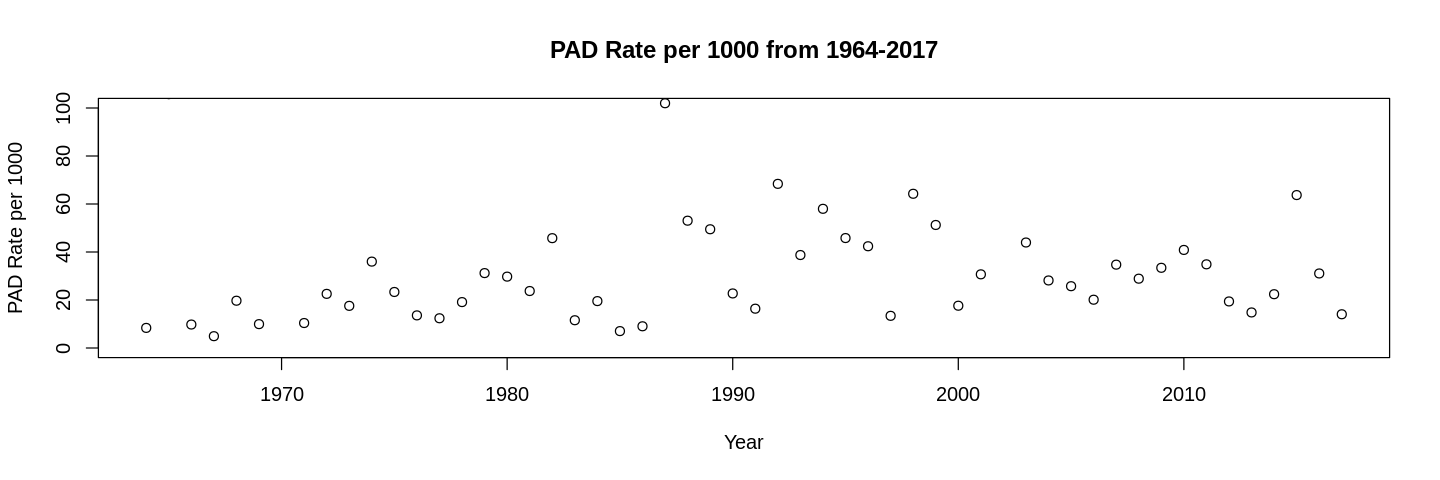

In [ ]:
pad.ts <- ts(pad_per_1000, start = c(1964, 1), frequency = 1)
plot(pad.ts, type = 'p', main = "PAD Rate per 1000 from 1964-2017", xlab='Year', ylab='PAD Rate per 1000', ylim = c(0,100))


### Annual Precipitation in Kerala: A Similar Dataset to El Nino Patterns
A dataset that exhibits similar patterns to El Nino is annual rainfall data in India over the same timespan. Because El Nino affects weather patterns, it makes sense for precipitation levels in India to have similar periodic behavior to El Nino. The link to the source of this dataset is https://data.world/rajanand/rainfall-in-india/. 

I chose this dataset because El Nino affects precipitation, particularly in India (Lam, 2019). Furthermore, if PAD is correlated with El Nino years and PAD rates are influenced by precipitation/flooding events, then I predict that this dataset will have some similarities to ENSO indices.

In [ ]:
india.precipitation <- read.csv('rainfallindia.csv')
head(india.precipitation)

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan.Feb,Mar.May,Jun.Sep,Oct.Dec
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ANDAMAN & NICOBAR ISLANDS,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,481.1,332.6,388.5,558.2,33.6,3373.2,136.3,560.3,1696.3,980.3
2,ANDAMAN & NICOBAR ISLANDS,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,753.7,666.2,197.2,359.0,160.5,3520.7,159.8,458.3,2185.9,716.7
3,ANDAMAN & NICOBAR ISLANDS,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,326.7,339.0,181.2,284.4,225.0,2957.4,156.7,236.1,1874.0,690.6
4,ANDAMAN & NICOBAR ISLANDS,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,160.1,820.4,222.2,308.7,40.1,3079.6,24.1,506.9,1977.6,571.0
5,ANDAMAN & NICOBAR ISLANDS,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,330.5,297.0,260.7,25.4,344.7,2566.7,1.3,309.7,1624.9,630.8
6,ANDAMAN & NICOBAR ISLANDS,1906,36.6,0.0,0.0,0.0,556.1,733.3,247.7,320.5,164.3,267.8,128.9,79.2,2534.4,36.6,556.1,1465.8,475.9


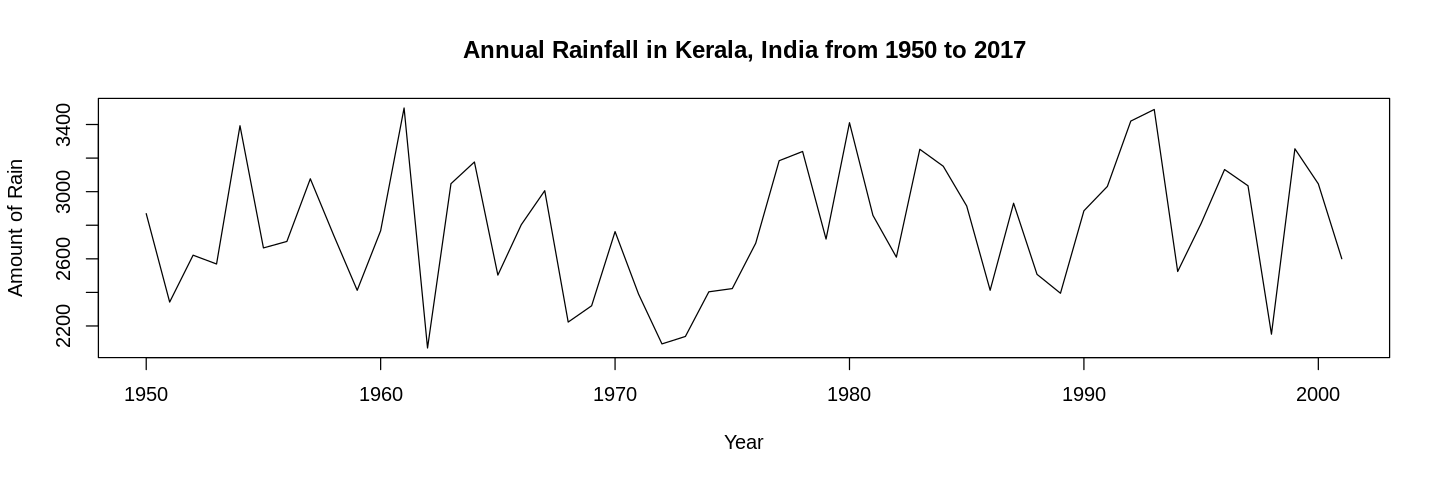

In [ ]:
filter = india.precipitation$SUBDIVISION == 'KERALA' & india.precipitation$YEAR > 1963
kerala.annual = india.precipitation[filter, 'ANNUAL']
kerala.ts <- ts(kerala.annual, start = c(1950, 1), frequency = 1)
plot(kerala.ts, main = "Annual Rainfall in Kerala, India from 1950 to 2017", xlab = 'Year', ylab = "Amount of Rain")

In [ ]:
kerala <- india.precipitation[filter,]
kerala[kerala$ANNUAL > 3100,]

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan.Feb,Mar.May,Jun.Sep,Oct.Dec
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3955,KERALA,1968,7.3,30.5,89.2,133.3,90.0,696.4,1308.9,380.7,325.4,178.9,119.4,32.7,3392.7,37.8,312.5,2711.4,331.0
3962,KERALA,1975,5.2,21.4,63.4,123.8,162.2,864.4,531.3,675.9,457.7,368.9,204.3,19.9,3498.4,26.6,349.3,2529.3,593.1
3965,KERALA,1978,3.3,14.7,31.4,73.9,396.8,758.1,686.7,516.8,119.4,171.0,365.6,39.0,3176.7,18.0,502.1,2081.1,575.6
3978,KERALA,1991,10.9,4.4,33.2,97.0,113.4,1096.1,905.5,465.5,48.5,307.8,99.9,2.3,3184.5,15.3,243.6,2515.6,410.0
3979,KERALA,1992,2.4,0.9,0.1,43.0,218.4,819.3,767.8,508.0,297.5,290.7,287.6,3.7,3239.5,3.4,261.6,2392.5,582.1
3981,KERALA,1994,24.3,27.1,18.1,154.5,141.3,845.0,955.5,479.9,212.6,428.4,117.6,6.5,3410.8,51.4,313.9,2493.0,552.5
3984,KERALA,1997,2.1,1.5,36.1,60.6,133.6,544.2,970.5,536.0,292.2,288.9,298.4,88.4,3252.4,3.7,230.2,2342.9,675.7
3985,KERALA,1998,6.0,2.1,8.1,61.1,151.6,732.5,641.4,371.8,517.6,444.8,135.0,79.4,3151.5,8.0,220.8,2263.4,659.3
3993,KERALA,2006,8.1,0.5,90.7,65.3,521.2,482.4,804.0,432.6,474.8,376.4,162.8,1.8,3420.6,8.6,677.2,2193.8,541.0


##Section 2: Investigating the Data


---


I am going to start by examining the autocorrelation and autocovariance plots for the ONI time series data. Below, I use the built-in acf function to plot the autocovariance and autocorrelation of the ONI time series. I set the plot parameter to false so that I can use the built-in plot function to modify the title.

###ONI Data Investigation

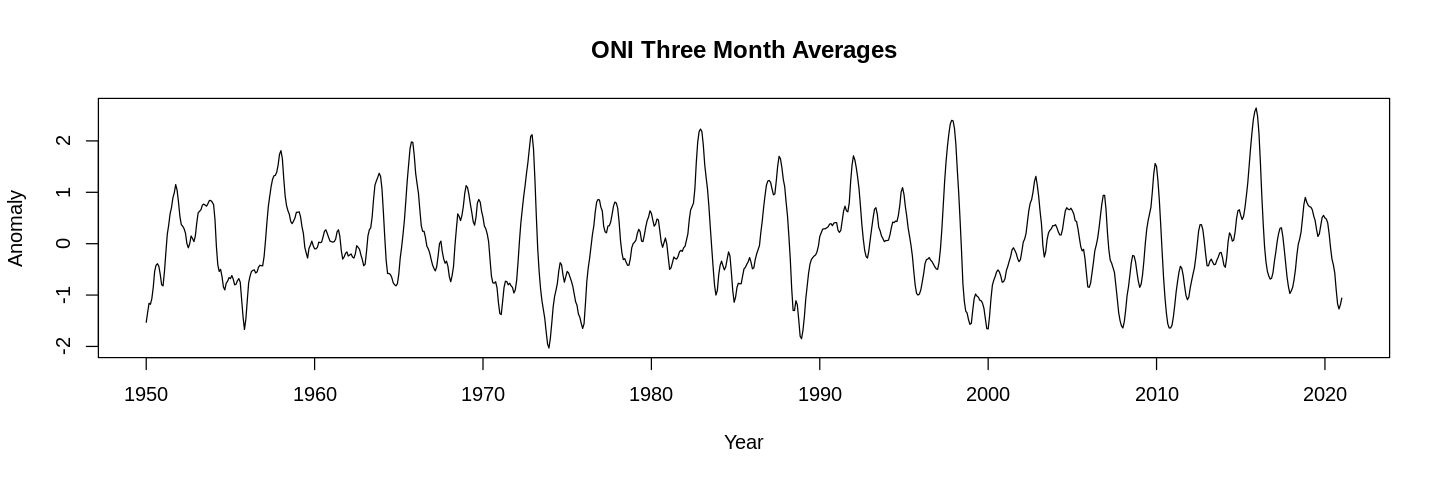

In [ ]:
three.month.oni.ts <- ts(oni.df$ANOM, start = c(1950, 1), frequency = 12)
plot(three.month.oni.ts, type = 'l', ylab = 'Anomaly', xlab = 'Year', main = 'ONI Three Month Averages')

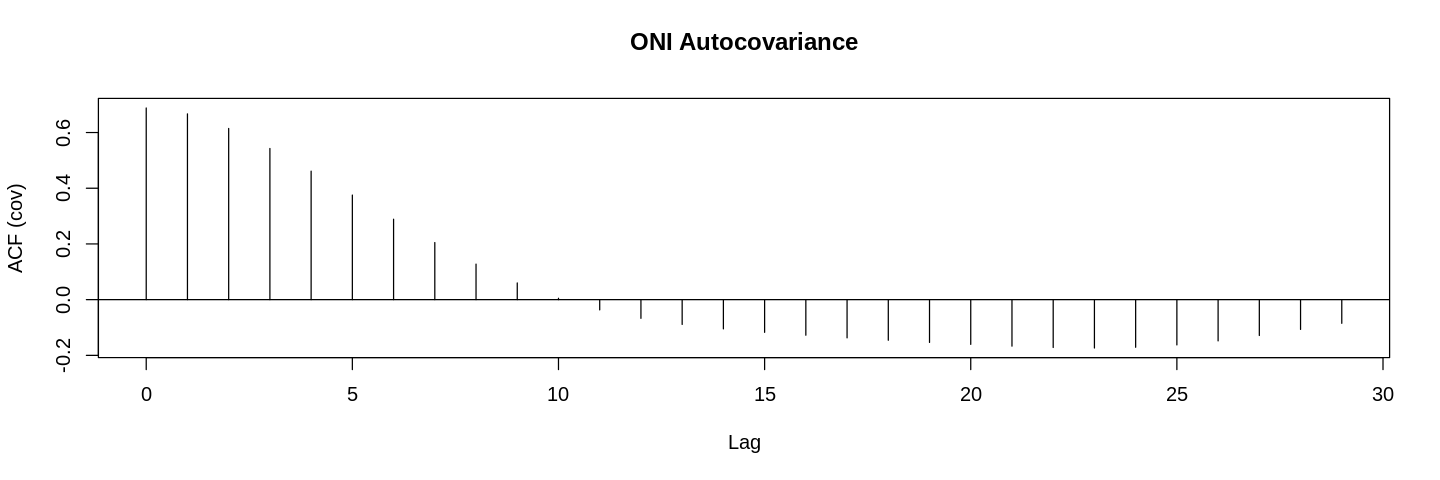

In [ ]:
plot(acf(oni.df$ANOM, type = 'covariance', plot = F), main = 'ONI Autocovariance')

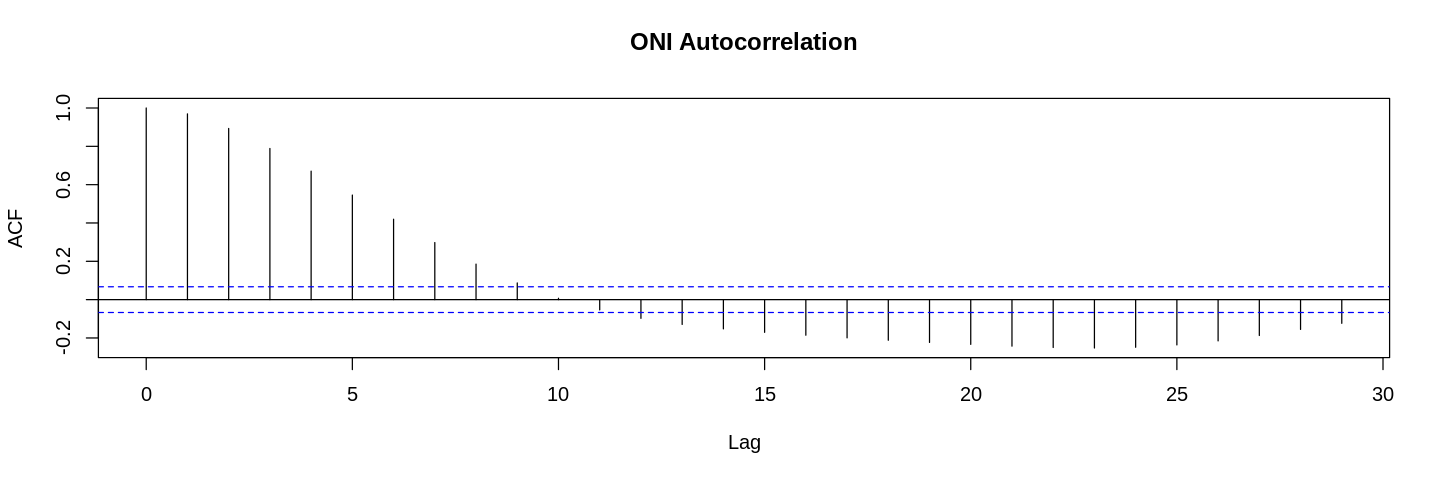

In [ ]:
plot(acf(oni.df$ANOM, type = 'correlation', plot = F), main = 'ONI Autocorrelation')

**Interpretation** The autocorrelation seems to drop off around 7-10 lags but is high up until then.

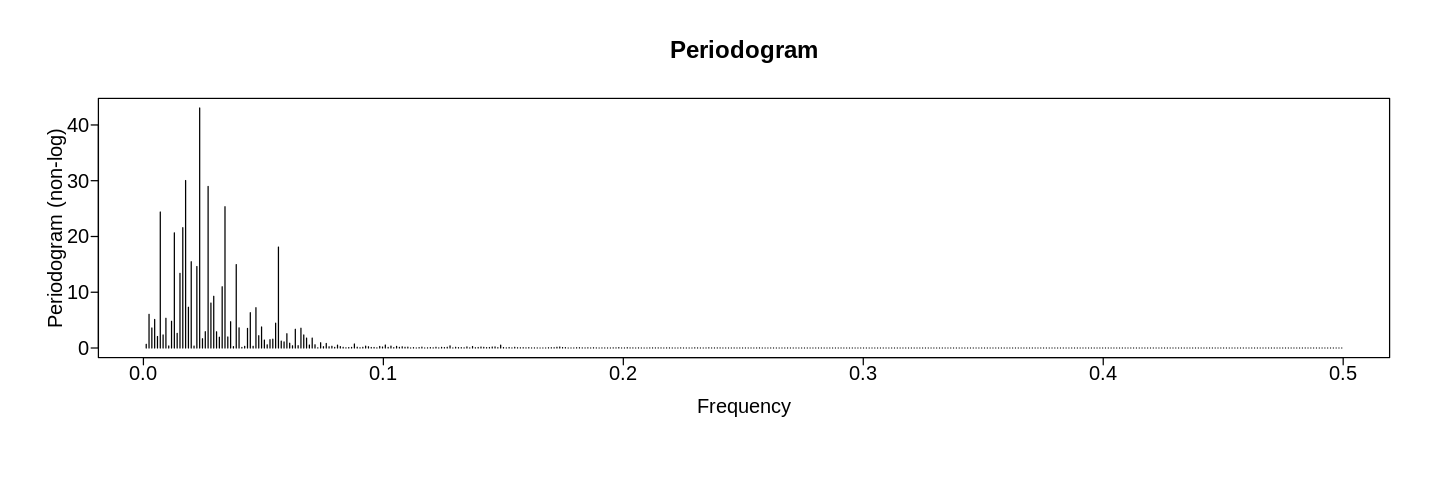

In [ ]:
oni.periodogram <- period.wge(oni.df$ANOM, dbcalc=F)


Because I will be getting the dominant frequencies for MEI, ONI, and PAD data, I wrote a generalizable function that can return the dominant frequency values for a particular periodogram. 

In [ ]:
get_dominant_freqs <- function(filter, pgram) {
  index = 1 
  dom_freqs = c()
  for (bool in filter) {
    if (bool) {
      cat("Periodogram Value:", pgram$pgram[index], "\nDominant Frequency", pgram$freq[index], "\n\n")
      dom_freqs <- append(dom_freqs, pgram$freq[index])
    }
    index = index + 1
  }
  return(dom_freqs)
}

I filtered when the periodogram value was greater than 35 based on the plot to get the dominant frequency by visually inspecting what threshold the dominant frequency was above.

In [ ]:
filter <- oni.periodogram$pgram > 35
dom.freq.oni <- get_dominant_freqs(filter, oni.periodogram)
oni.period <- 1/dom.freq.oni
cat('Period:', oni.period)

Periodogram Value: 43.0398 
Dominant Frequency 0.02344666 

Period: 42.65

**Interpretation**: The ONI dataset yieled a potential period of 42.65 months based on the dominant frequency of 0.02 Hz. This means that ENSO indices may be recurrent on a periodic basis in terms of their magnitude.

###MEI Data Investigation

I am repeating the same steps for the MEI data and using the same functions. 

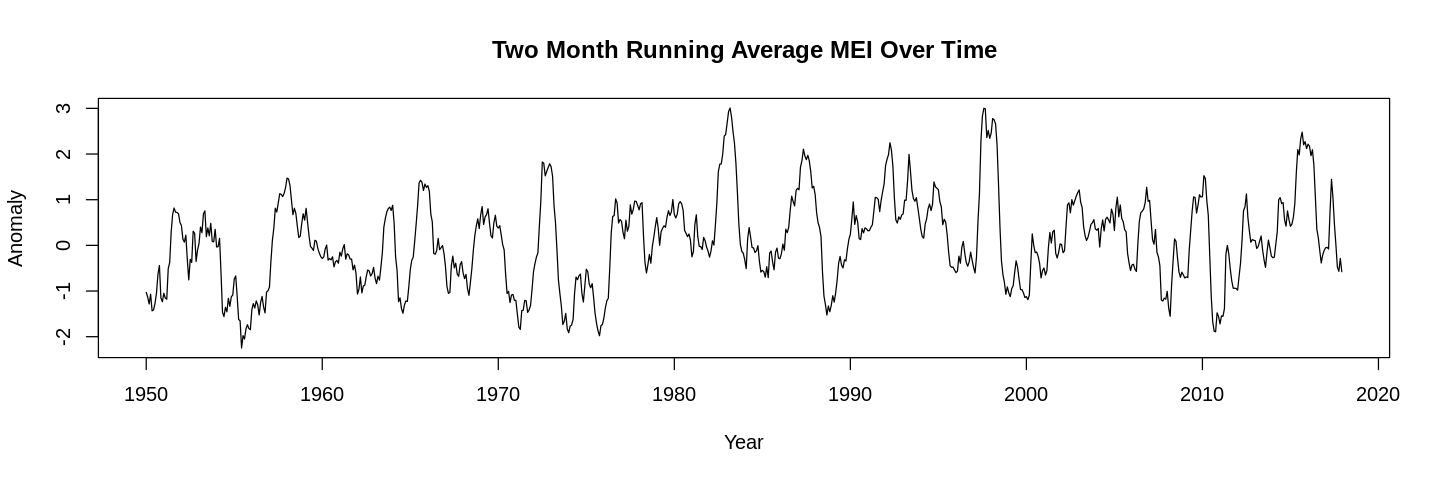

In [ ]:
mei.data <- as.vector(t(mei.df[,2:length(my.cols)])) # Getting the right format
mei.data.ts <- ts(mei.data, start = c(1950, 1), frequency = 12)
plot(mei.data.ts, type = 'l', ylab = 'Anomaly', xlab = 'Year', main = 'Two Month Running Average MEI Over Time')

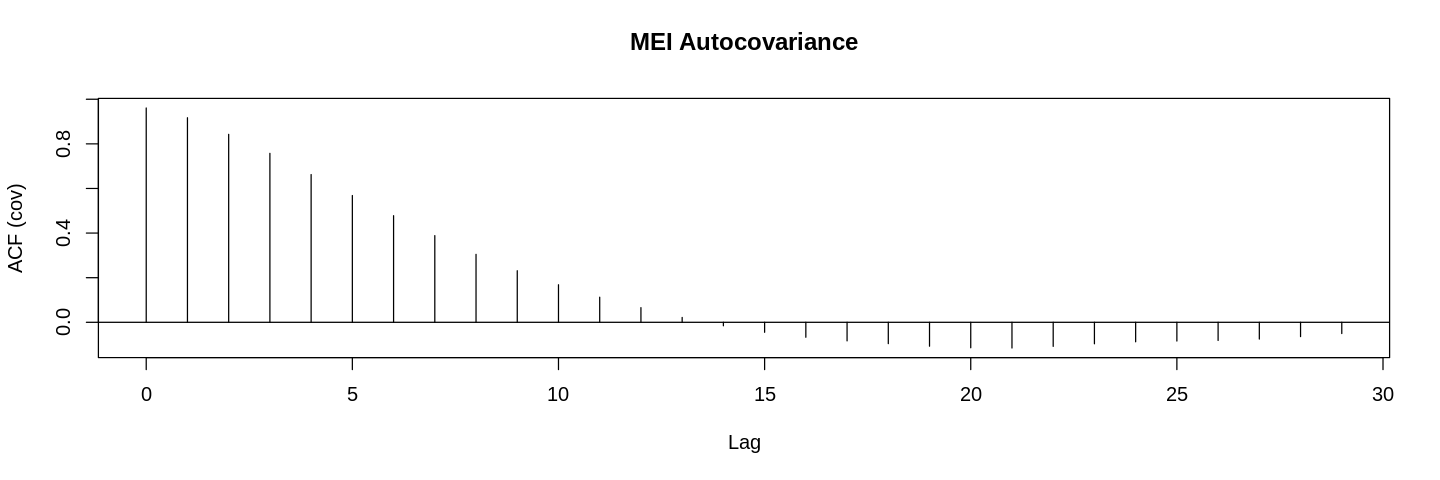

In [ ]:
plot(acf(mei.data, type = 'covariance', plot = FALSE), main = 'MEI Autocovariance')

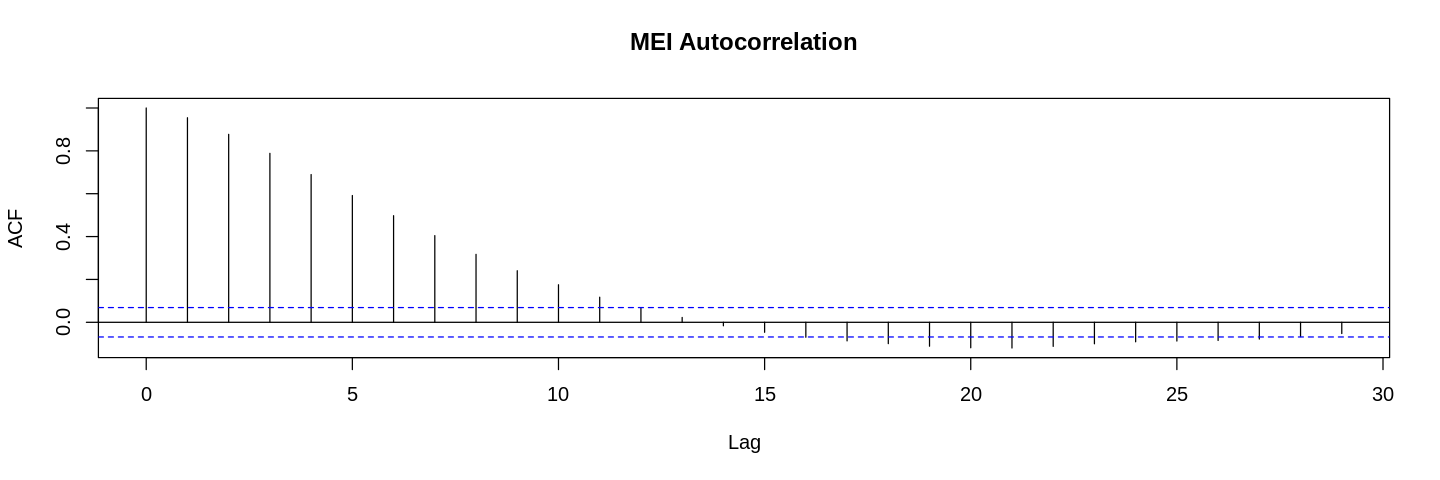

In [ ]:
plot(acf(mei.data, type = 'correlation', plot = FALSE), main = 'MEI Autocorrelation')

**Interpretation** Similar to the ONI dataset, the autocorrelation seems to drop off around 7-10 lags but remains high before that point.

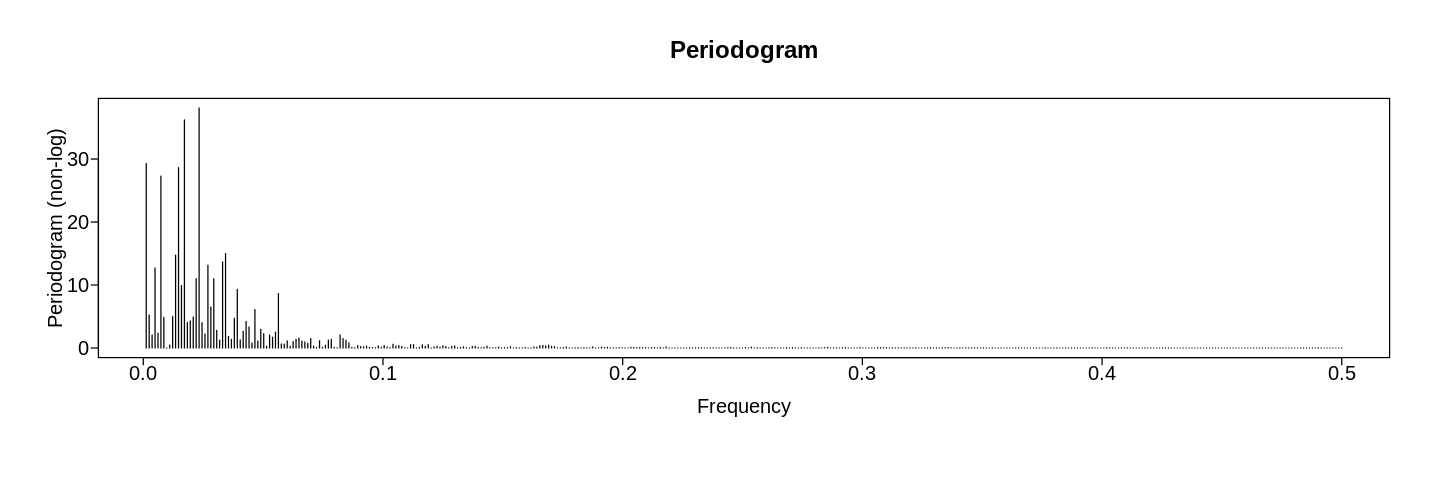

In [ ]:
mei.periodogram <- period.wge(mei.data, dbcalc = FALSE, plot = TRUE)

In [271]:
filter = mei.periodogram$pgram > 30
mei.dom.freqs <- get_dominant_freqs(filter, mei.periodogram)
mei.periods <- 1/mei.dom.freqs
cat('Periods:', mei.periods)

Periodogram Value: 36.21038 
Dominant Frequency 0.01715686 

Periodogram Value: 38.09929 
Dominant Frequency 0.02328431 

Periods: 58.28571 42.94737

**Interpretation**: The MEI dataset yieled two potential periods of 58,2 and 42,9 months based on the dominant frequencies of 0.02 Hz and .017 Hz. Similar to the interpretation for ONI, these periods mean that ENSO indices may be recurrent on a periodic basis in terms of their magnitude. Furthermore, these numbers seem accurate as they are quite similar to the period numbers calculated for ONI. 

### PAD Data Investigation

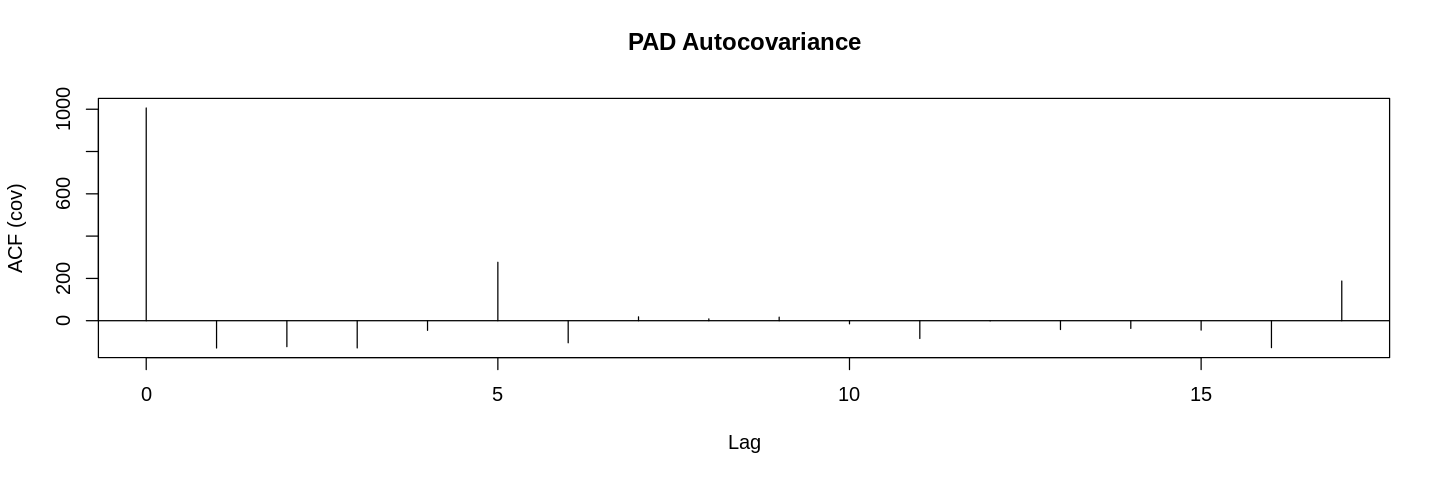

In [ ]:
pad.covariance <- acf(pad_per_1000, type = 'covariance', plot = F)
plot(pad.covariance, main = 'PAD Autocovariance')

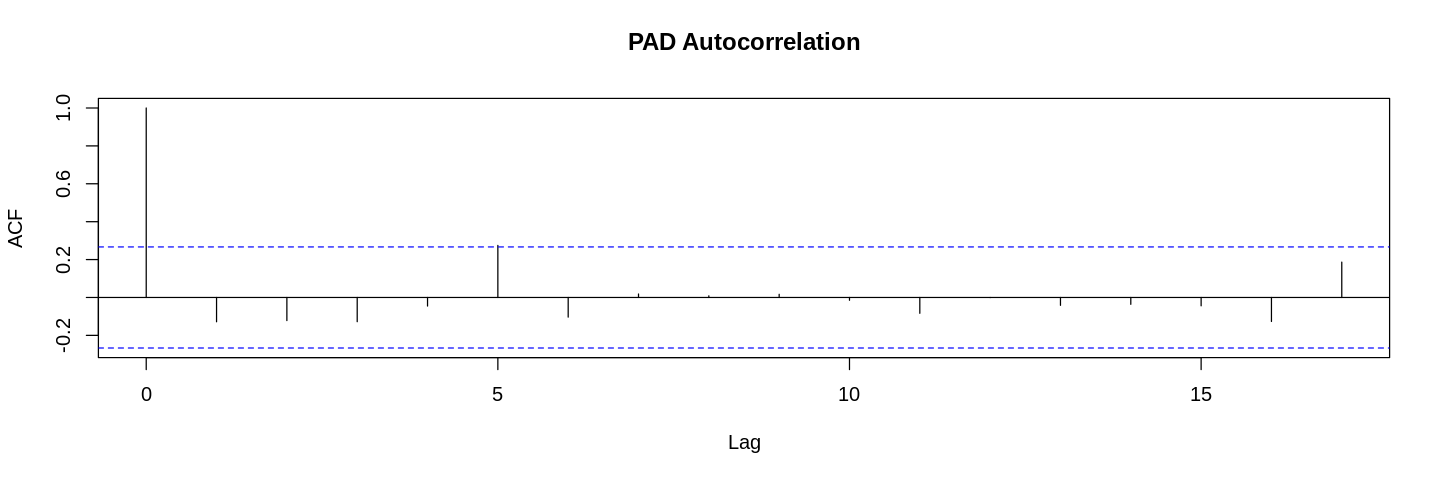

In [ ]:
pad.correlation <- acf(pad_per_1000, type = 'correlation', plot = F)
plot(pad.correlation, main = 'PAD Autocorrelation') 

**Interpretation** The autocorrelation changes between being negative and positive. The autocorrelation is really only high at a lag of zero and somewhat high at a lag of 5.

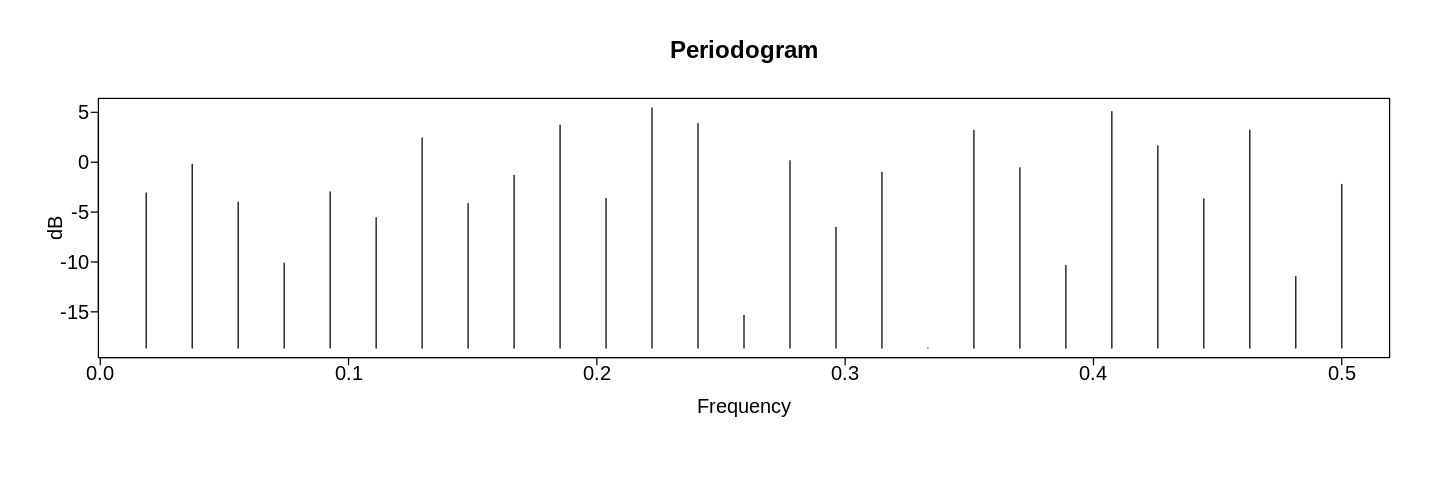

In [ ]:
pad.periodogram <- period.wge(pad.ts, plot = TRUE)

In [272]:
filter <- pad.periodogram$pgram > 4
pad.dom.freqs <- get_dominant_freqs(filter, pad.periodogram)
pad.periods <- 1/pad.dom.freqs
cat('PAD Period Values:', pad.periods)

Periodogram Value: 5.434779 
Dominant Frequency 0.2222222 

Periodogram Value: 5.065529 
Dominant Frequency 0.4074074 

PAD Period Values: 4.5 2.454545

**Interpretation**: The PAD dataset yieled potential periods of 4.5 years and 2.45 years based on the dominant frequencies of .22 Hz and .40 Hz. These results line up with what would be expected given that El Nino events typically recurr every 3-7 years (El Nino information, 2021). 

###India Precipitation Data Investigation

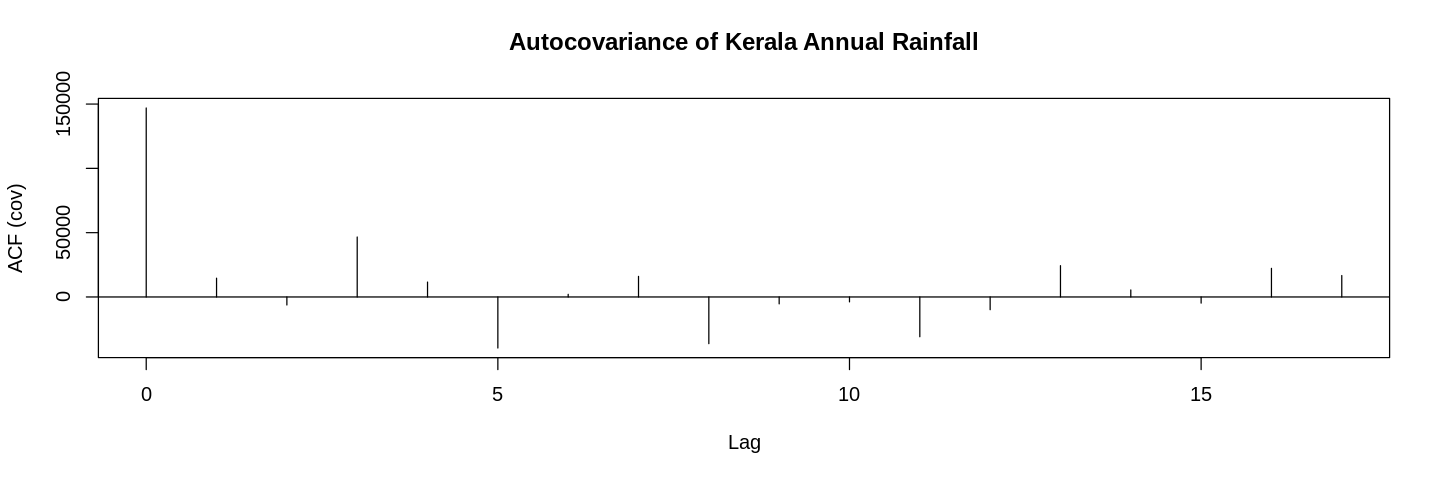

In [ ]:
kerala.covariance = acf(kerala.ts, type = 'covariance', plot = FALSE)
plot(kerala.covariance, main = 'Autocovariance of Kerala Annual Rainfall')

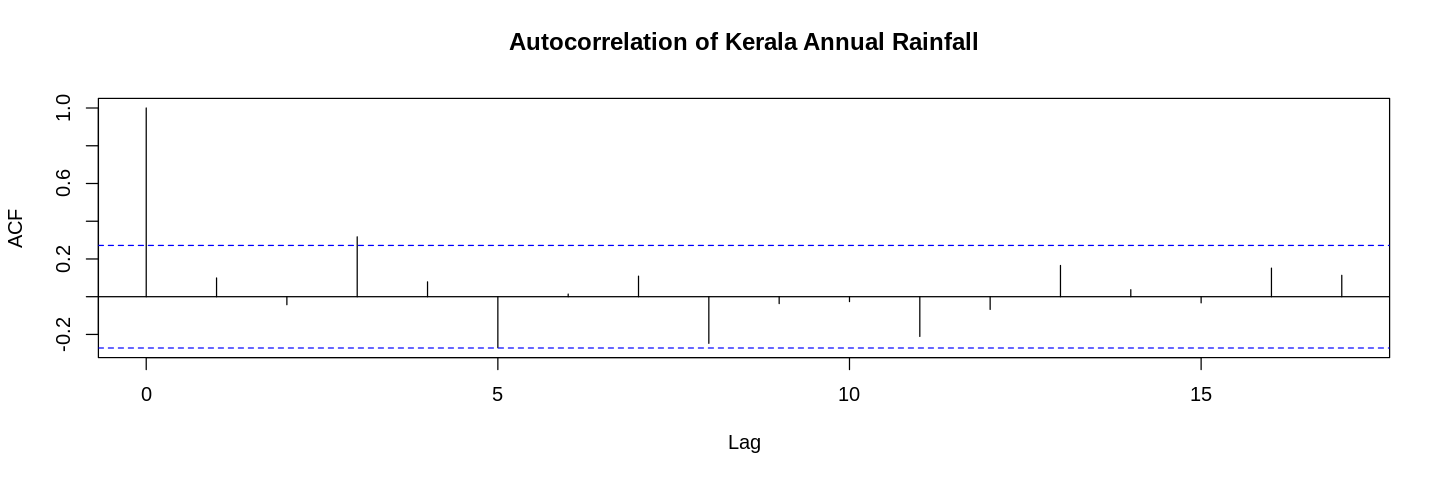

In [ ]:
kerala.correlation = acf(kerala.ts, type = 'correlation', plot = FALSE)
plot(kerala.correlation, main = 'Autocorrelation of Kerala Annual Rainfall')

**Interpretation** Similar to the PAD data, the autocorrelation changes between positive and negative and is highest at zero as expected. There are a couple of smaller peaks at around 3 lags and 5 lags. 

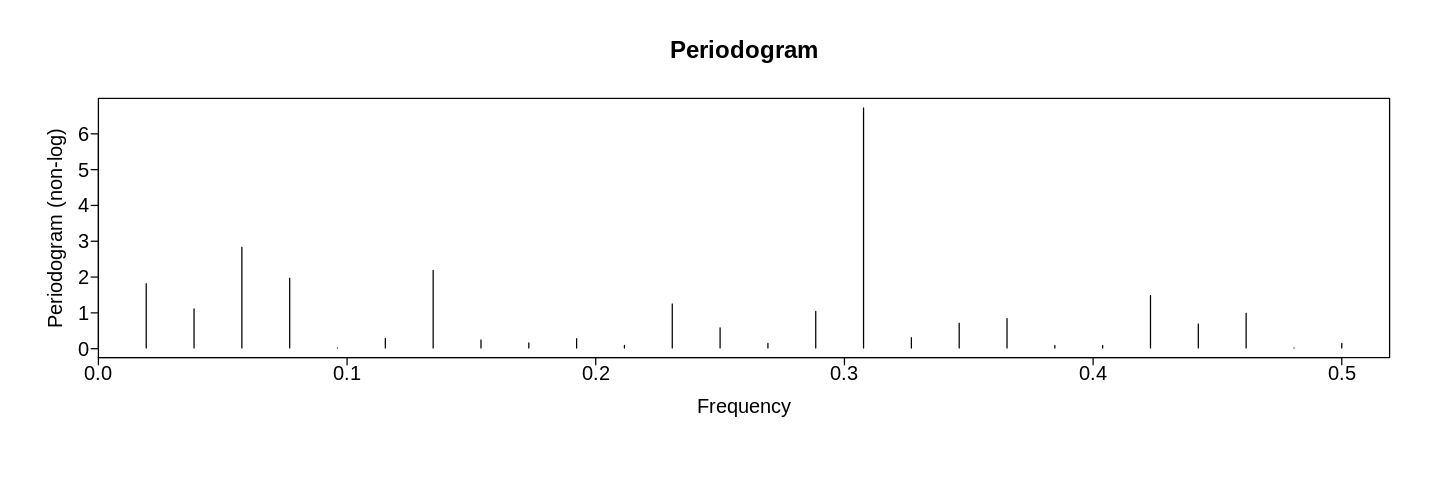

In [ ]:
kerala.periodogram <- period.wge(kerala.ts, dbcalc = FALSE, plot = TRUE)

In [273]:
filter = kerala.periodogram$pgram > 4.5
kerala.dom.freqs <- get_dominant_freqs(filter, kerala.periodogram)
kerala.periods <- 1/kerala.dom.freqs
cat("Period:", kerala.periods)

Periodogram Value: 6.721288 
Dominant Frequency 0.3076923 

Period: 3.25

**Interpretation**: The Kerala dataset yielded a potential period of 3.25 years from the dominant frequency of .30 Hz derived. As predicted, this period value is similar to the period value calculated from the PAD dataset which indicates similar patterns between the two distinct datasets.

##Deriving El Nino Years 
Based on the metrics in the paper, I derived the likely El Nino years by subsetting the dataframes by the appropriate month (DECJAN for MEI and DJF for ONI) as well as where the values were greater than 0.5 degrees Celsius.

In [ ]:
filter <- mei.df$DECJAN > 0.5
mei.el.nino <- mei.df[filter,c('YEAR', 'DECJAN')]

In [ ]:
filter <- oni.df$SEAS == 'DJF' & oni.df$ANOM > 0.5
oni.el.nino <- oni.df[filter,]

In [ ]:
oni.el.nino

,SEAS,YR,TOTAL,ANOM
,<chr>,<int>,<dbl>,<dbl>
25,DJF,1952,26.78,0.53
49,DJF,1954,27.00,0.76
97,DJF,1958,28.15,1.81
109,DJF,1959,26.95,0.61
169,DJF,1964,27.36,1.07
193,DJF,1966,27.72,1.37
229,DJF,1969,27.54,1.13
241,DJF,1970,26.93,0.51
277,DJF,1973,28.32,1.84


In [ ]:
mei.el.nino

,YEAR,DECJAN
,<dbl>,<dbl>
9,1958,1.473
10,1959,0.553
15,1964,0.878
17,1966,1.307
20,1969,0.670
24,1973,1.723
28,1977,0.529
29,1978,0.777
30,1979,0.608


From these two subsetted dataframes, I derived the probable El Nino years by seeing what common years there are between the two dataframes as these should be years with ENSO present. 

In [ ]:
el.nino.years <- intersect(mei.el.nino$YEAR, oni.el.nino$YR)
el.nino.years

[1] 1958 1959 1964 1966 1969 1973 1977 1978 1980 1983 1987 1988 1992 1995 1998
[16] 2003 2007 2010 2016

In [ ]:
stronger.el.ninos.mei <- mei.df[mei.df$DECJAN > 1.49 ,c('YEAR', 'DECJAN')]
stronger.el.ninos.oni <- oni.df[oni.df$SEAS == 'DJF' & oni.df$ANOM > 1.5,]

In [ ]:
stronger.el.ninos.mei

,YEAR,DECJAN
,<dbl>,<dbl>
24,1973,1.723
34,1983,2.677
43,1992,1.747
49,1998,2.455
67,2016,2.216


In [ ]:
stronger.el.ninos.oni

,SEAS,YR,TOTAL,ANOM
,<chr>,<int>,<dbl>,<dbl>
97,DJF,1958,28.15,1.81
277,DJF,1973,28.32,1.84
397,DJF,1983,28.79,2.18
505,DJF,1992,28.39,1.71
577,DJF,1998,28.87,2.24
793,DJF,2016,29.12,2.48


In [ ]:
stronger.ninos <- intersect(stronger.el.ninos.mei$YEAR, stronger.el.ninos.oni$YR)
stronger.ninos

[1] 1973 1983 1992 1998 2016

Based on the two indices, there were likely strong/very strong ENSO events in 1973, 1983, 1992, 1998, and 2016.

In [ ]:
weaker.el.ninos.mei <- mei.df[mei.df$DECJAN > 0.5 & mei.df$DECJAN < 1.5 ,c('YEAR', 'DECJAN')]
weaker.el.ninos.oni <- oni.df[oni.df$SEAS == 'DJF' & oni.df$ANOM > 0.5 & oni.df$ANOM < 1.5,]

In [ ]:
weaker.el.ninos.mei

,YEAR,DECJAN
,<dbl>,<dbl>
9,1958,1.473
10,1959,0.553
15,1964,0.878
17,1966,1.307
20,1969,0.670
28,1977,0.529
29,1978,0.777
30,1979,0.608
31,1980,0.677


In [ ]:
weaker.el.ninos.oni

,SEAS,YR,TOTAL,ANOM
,<chr>,<int>,<dbl>,<dbl>
25,DJF,1952,26.78,0.53
49,DJF,1954,27.00,0.76
109,DJF,1959,26.95,0.61
169,DJF,1964,27.36,1.07
193,DJF,1966,27.72,1.37
229,DJF,1969,27.54,1.13
241,DJF,1970,26.93,0.51
325,DJF,1977,27.18,0.71
337,DJF,1978,27.15,0.69


In [ ]:
weaker.ninos <- intersect(weaker.el.ninos.mei$YEAR, weaker.el.ninos.oni$YR)
weaker.ninos

[1] 1959 1964 1966 1969 1977 1978 1980 1987 1988 1995 2003 2007

Based on the intersection of the two indices, the weaker El Nino years (moderate or weak) were probably 1959, 1964, 1966, 1969, 1977, 1987, 1988, 1995, 2003, and 2007.

## Investigating El Nino Year with Frequency Domain and Autocorrelation Analysis

In [ ]:
el.nino.tracker <- list()
for (year in c(1950: 2017)) { 
  if (year %in% el.nino.years) { 
    el.nino.tracker[[year - 1949]] <- T
  }
  else {
    el.nino.tracker[[year - 1949]] <- F
  }
}

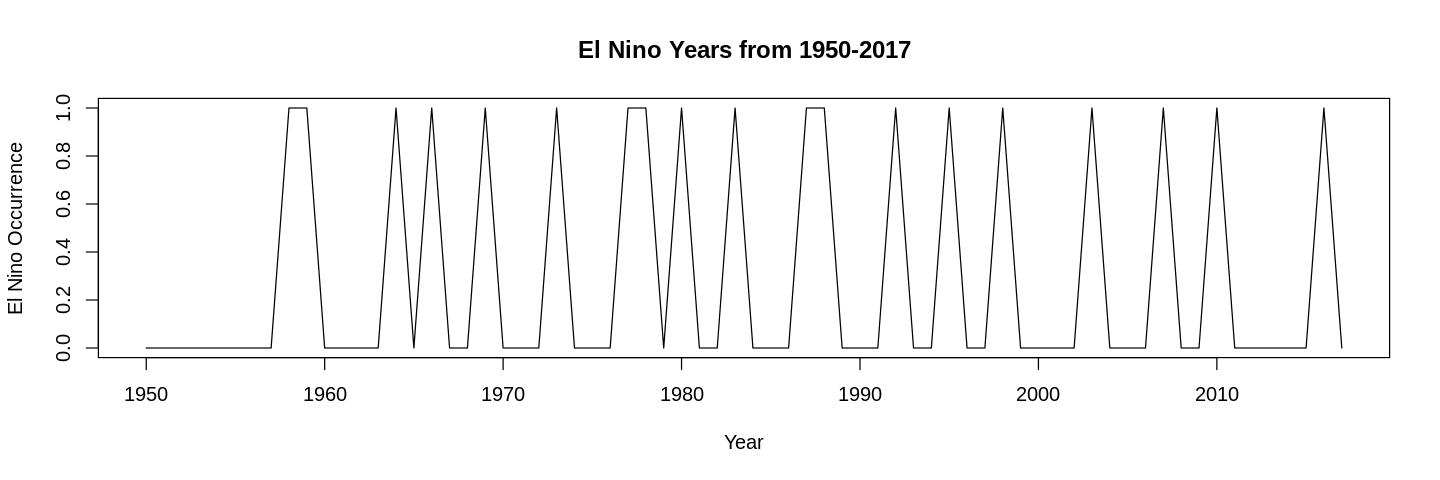

In [ ]:
years.ts <- ts(el.nino.tracker, start = 1950, frequency = 1)
plot(years.ts, main = 'El Nino Years from 1950-2017', ylab = 'El Nino Occurrence', xlab = 'Year')

In [ ]:
el.nino.tracker <- as.integer(el.nino.tracker)

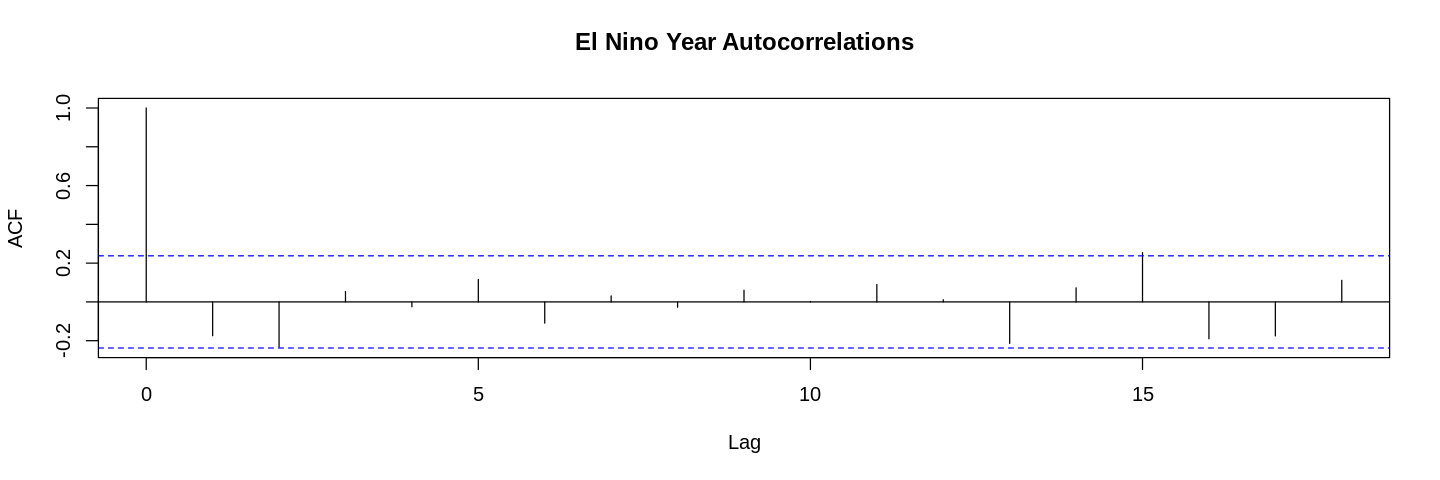

In [ ]:
acf(el.nino.tracker, type = 'correlation', main = 'El Nino Year Autocorrelations')

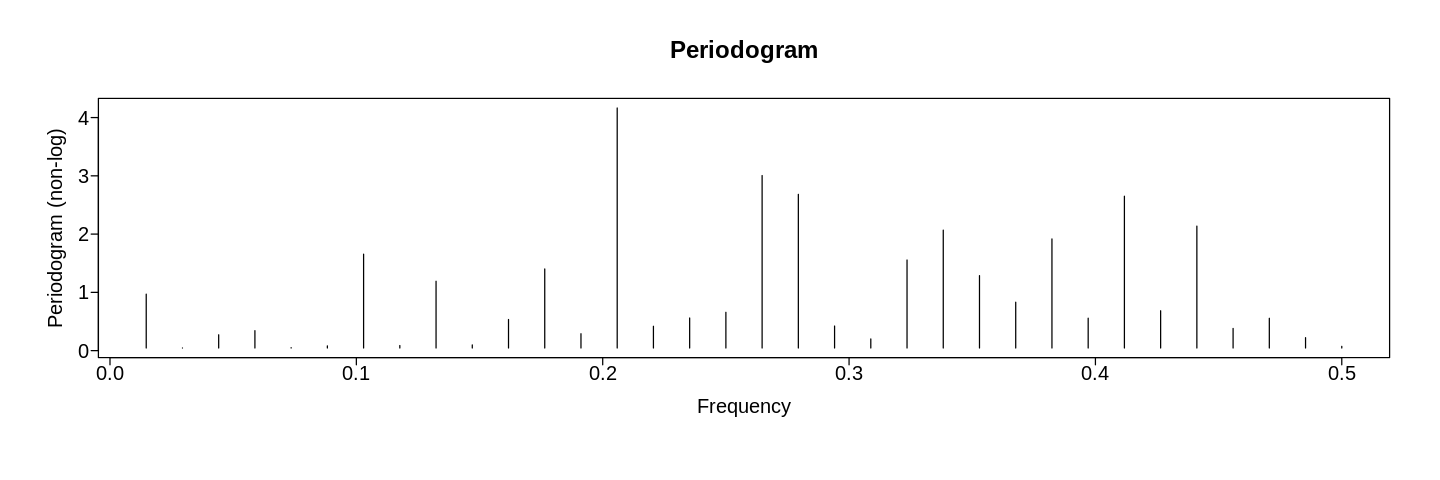

In [ ]:
years.pgram <- period.wge(el.nino.tracker, dbcalc = F)

In [ ]:
filter <- years.pgram$pgram > 3
years.dom.freqs <- get_dominant_freqs(filter, years.pgram)
periods <- 1/years.dom.freqs
cat('Potential periods', periods)

Periodogram Value: 4.164319 
Dominant Frequency 0.2058824 

Periodogram Value: 3.004631 
Dominant Frequency 0.2647059 

Potential periods 4.857143 3.777778

The dominant frequency/period of the El Nino years calculated above makes sense because El Nino events occur every 2-7 years (El Nino information, 2021). This analysis suggests that El Nino years recur every 4-5 years.

# Results

## Reproducing Figure 1
Refer to Section 1 of Methods to see the code to produce these plots. 

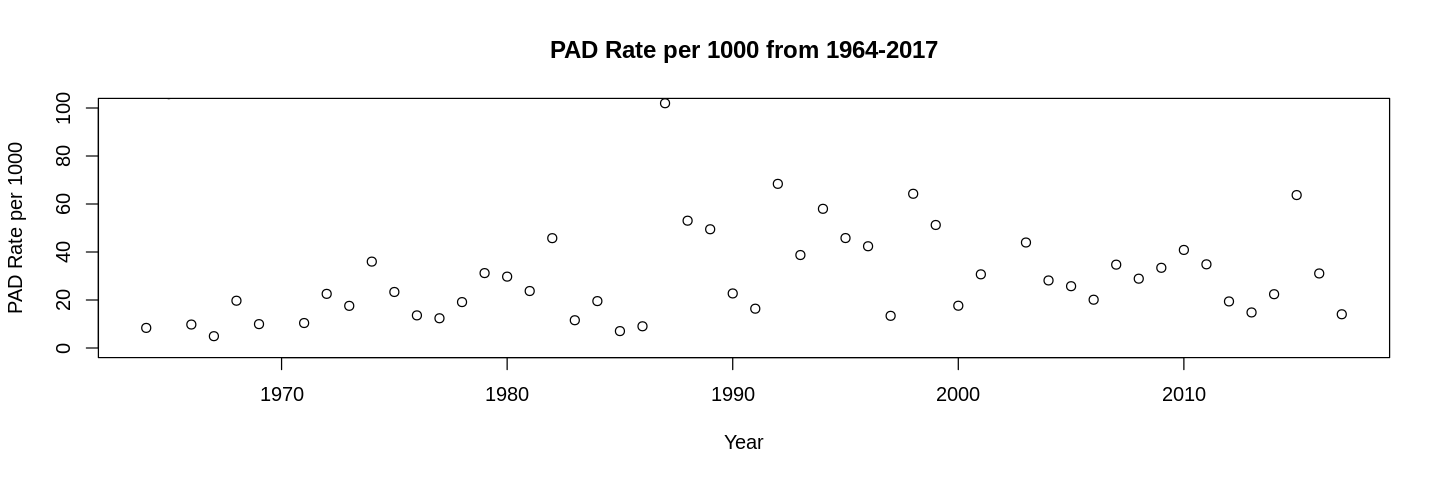

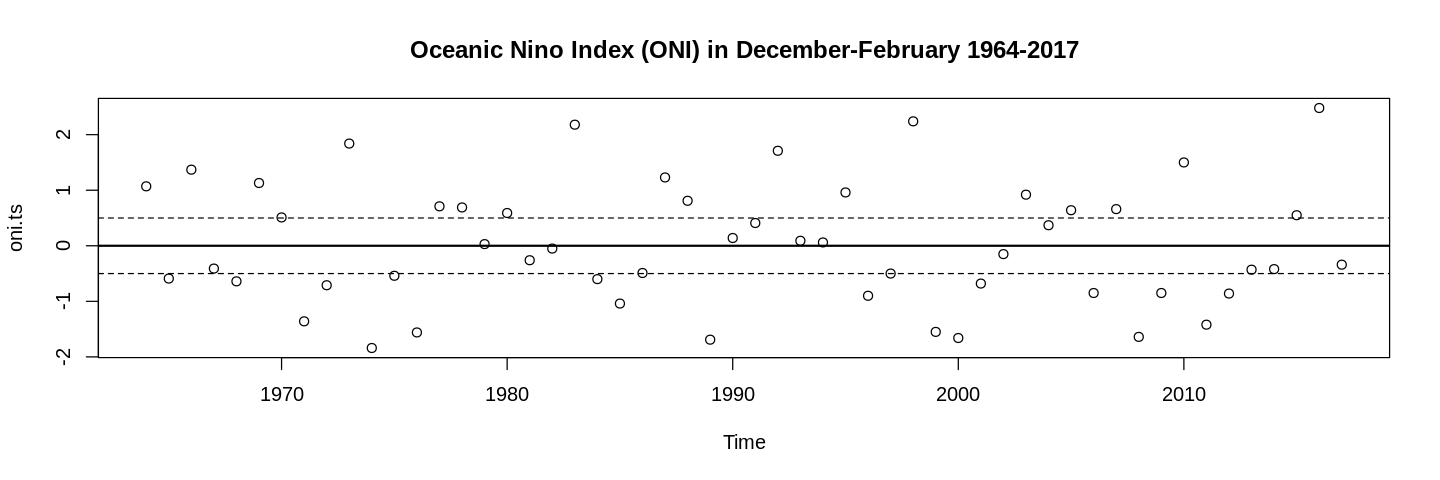

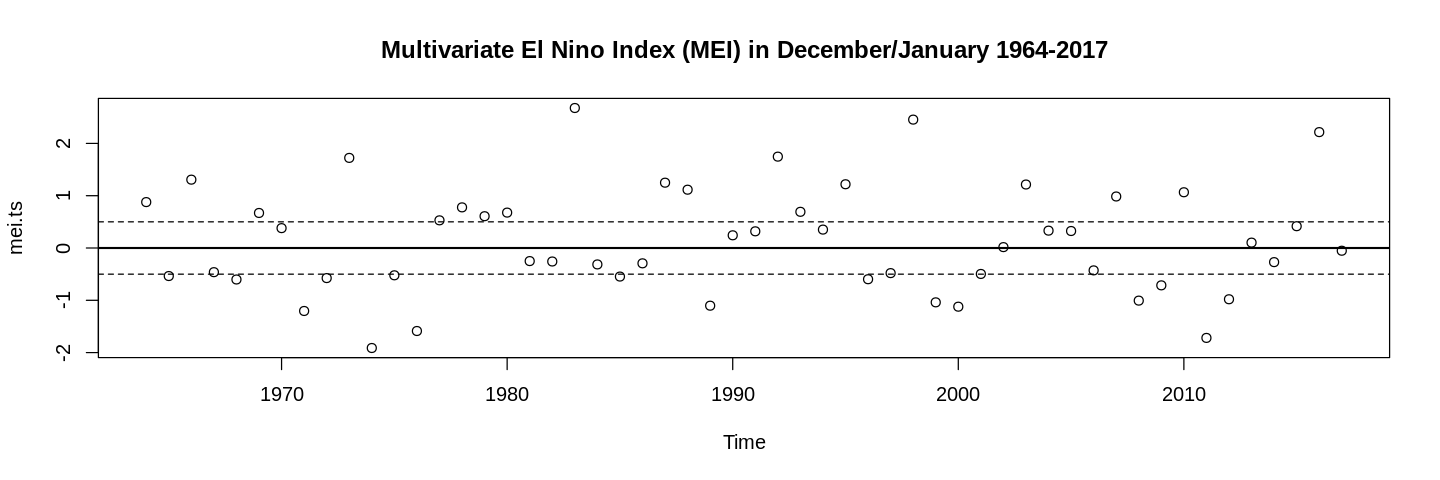

## Plots Using the Plotts Sample Wge Function
The data processing steps to get the time series input for this function can be found in section 1 of Methods. These plots show the realization, autocorrelation, periodogram, and Parzen window for the four datasets that I analyzed. Further interpretation of the periodogram and autocorrelation plot can be found in Section 1 of methods.

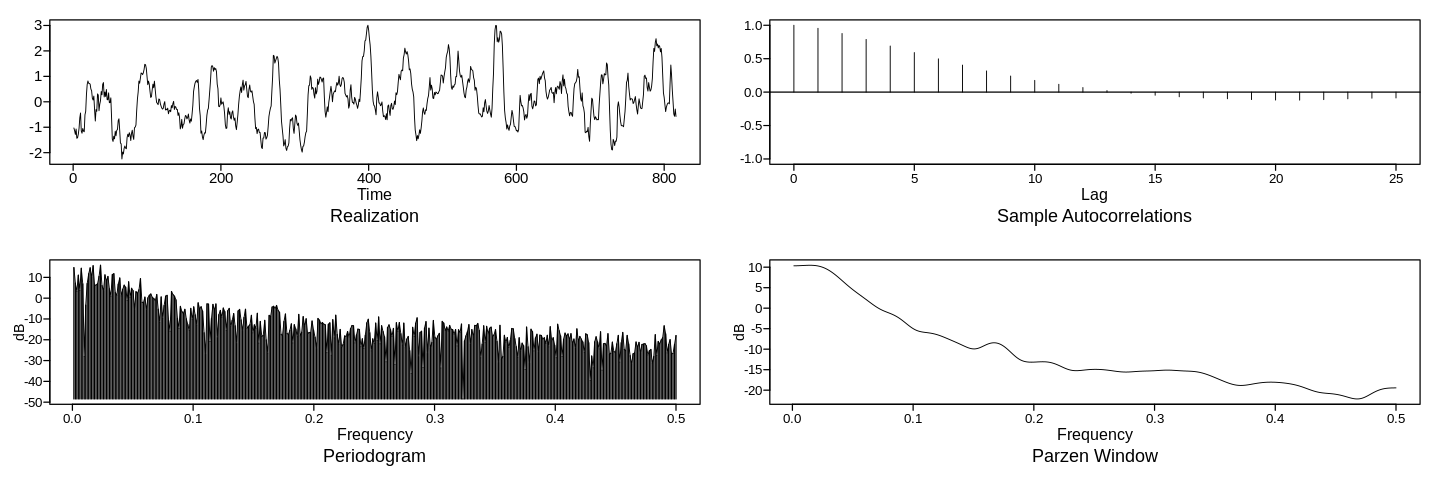

In [ ]:
mei.plt <- plotts.sample.wge(mei.data.ts)

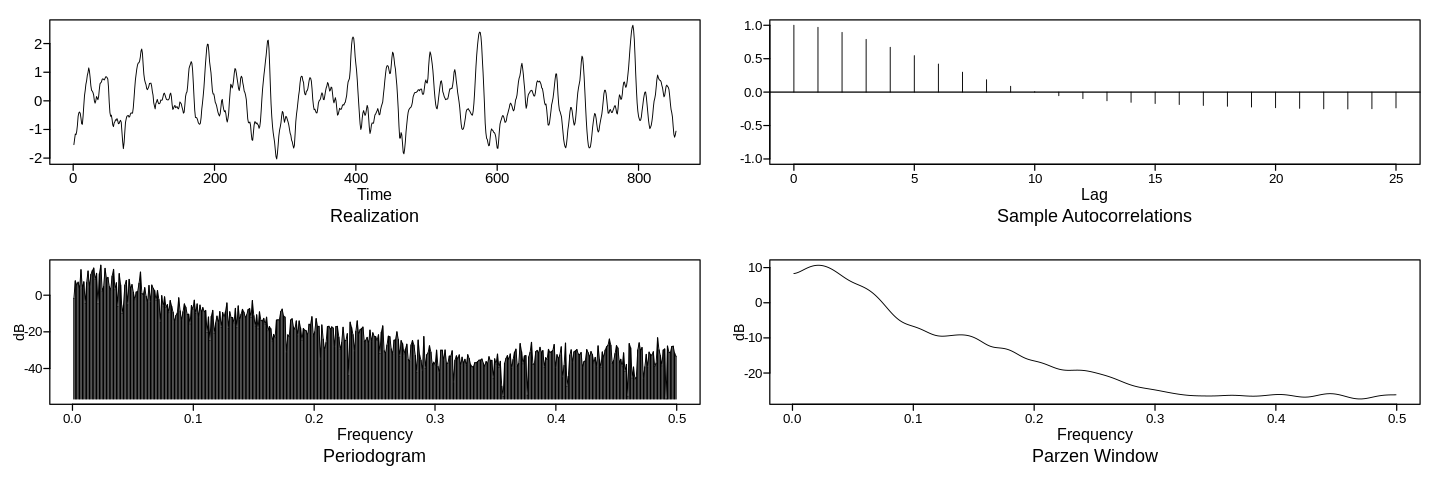

In [ ]:
oni.plt <- plotts.sample.wge(oni.df$ANOM)

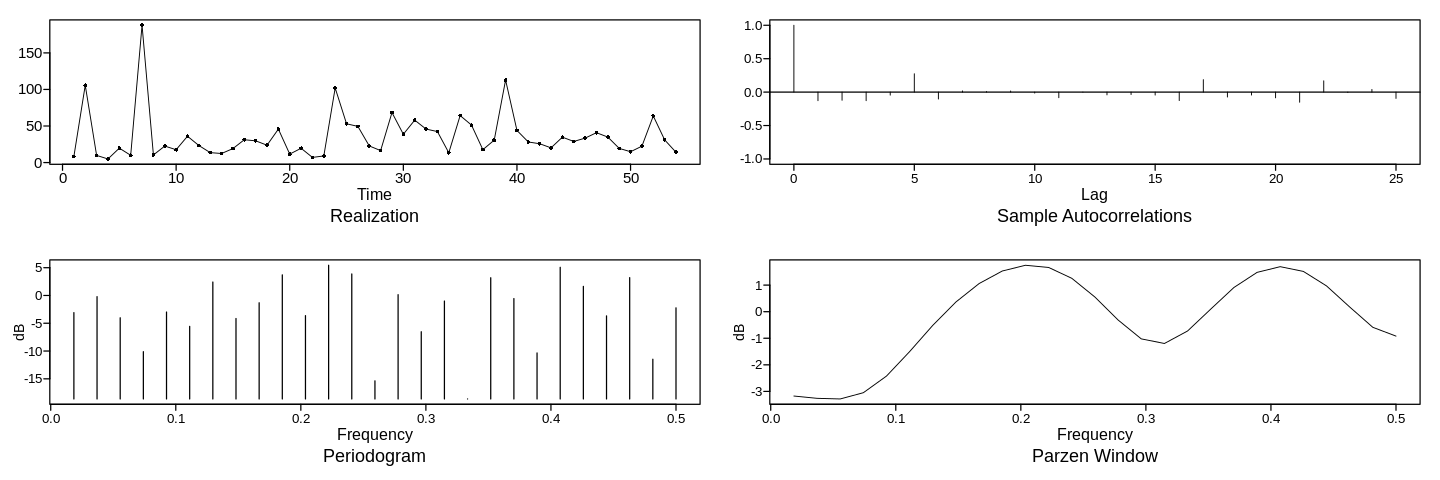

In [ ]:
pad.plt <- plotts.sample.wge(pad_per_1000)

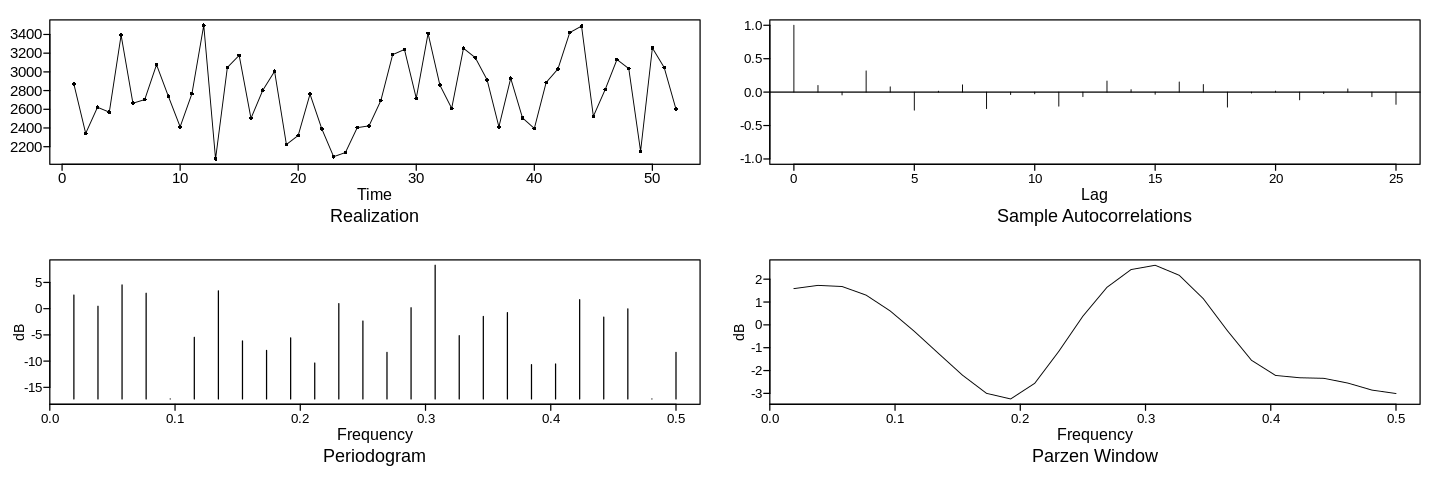

In [ ]:
india.plt <- plotts.sample.wge(kerala.ts)

## Periodograms and Autocorrelation Plots
The data cleaning to produce these plots can be found in Section 1 of methods along with interpretation of the results of these plots and the calculated dominant frequencies.

### ONI Autocorrelation Plot and Periodogram
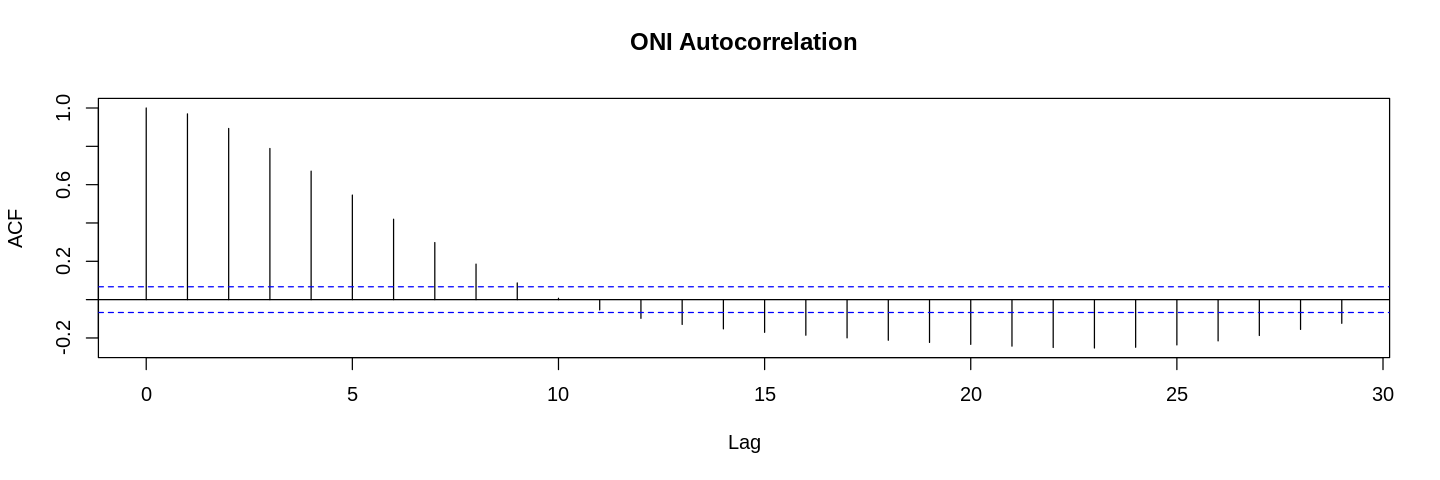




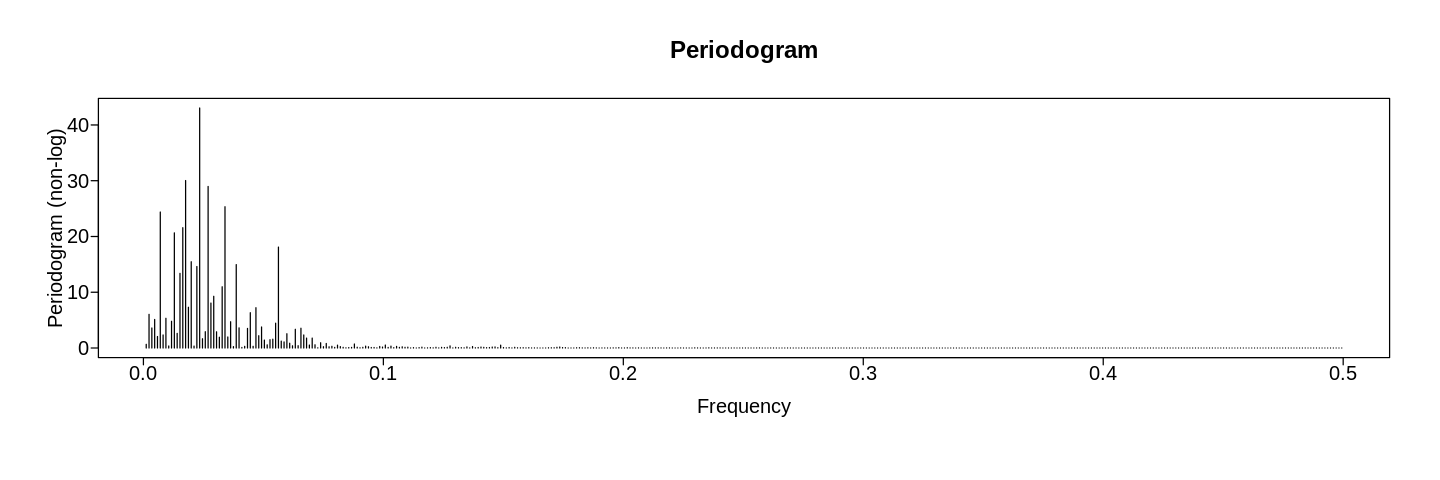

###MEI Autocorrelation Plot and Periodogram

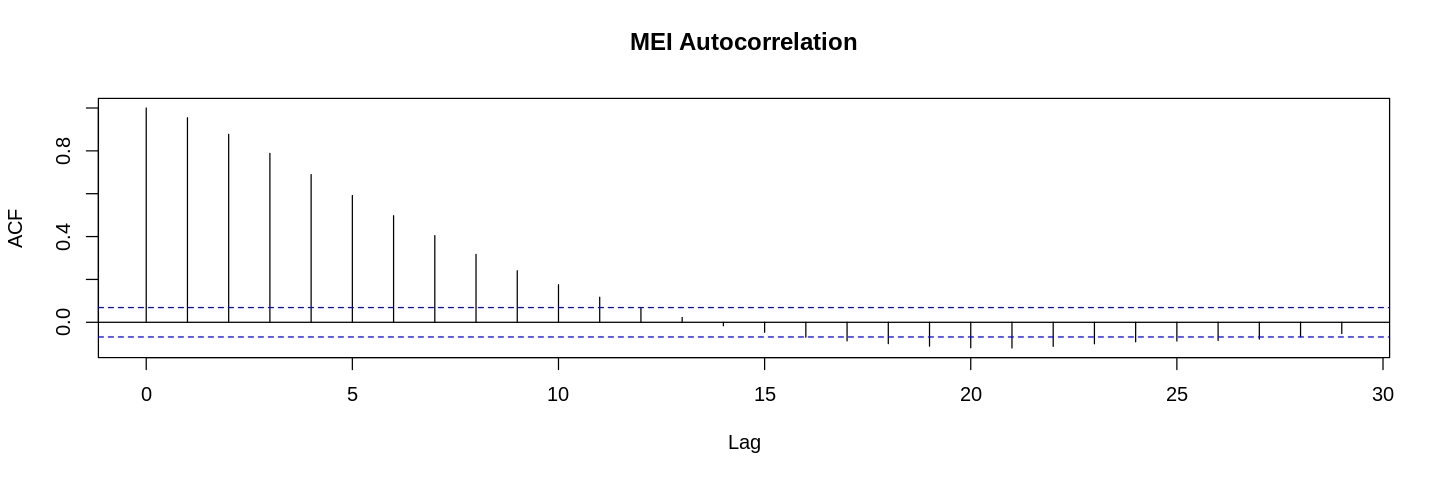

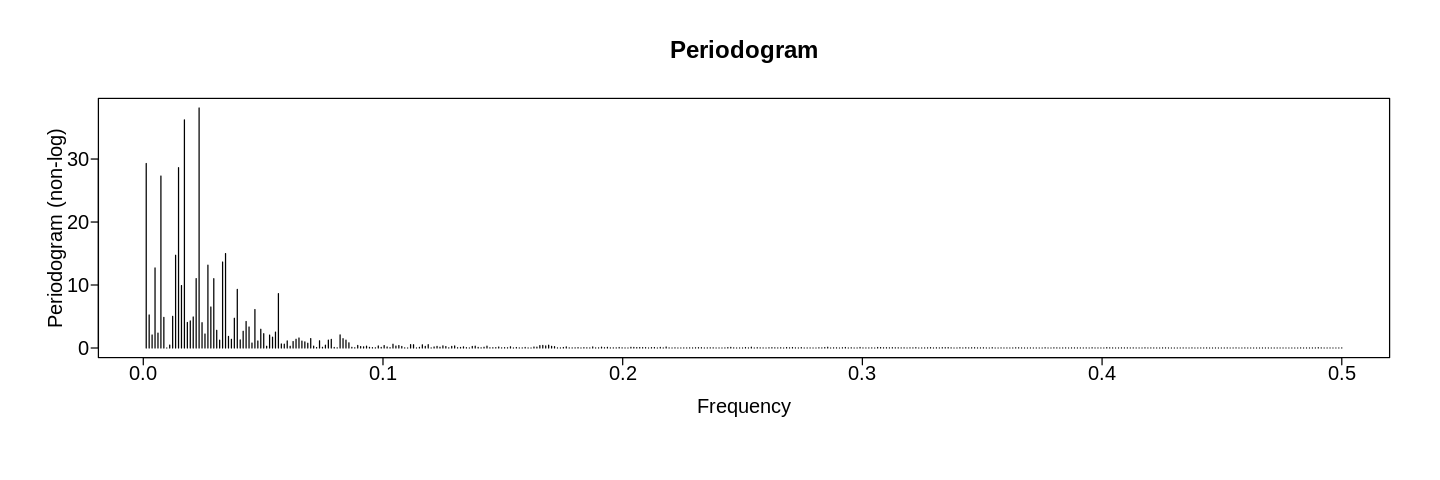

### PAD Autocorrelation Plot and Periodogram

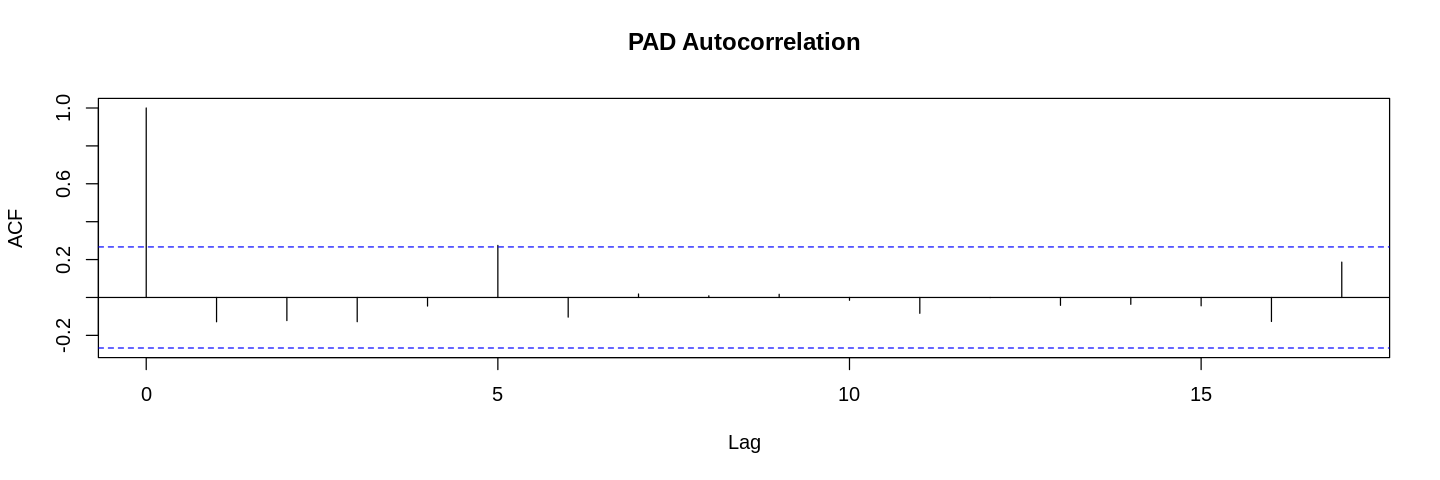

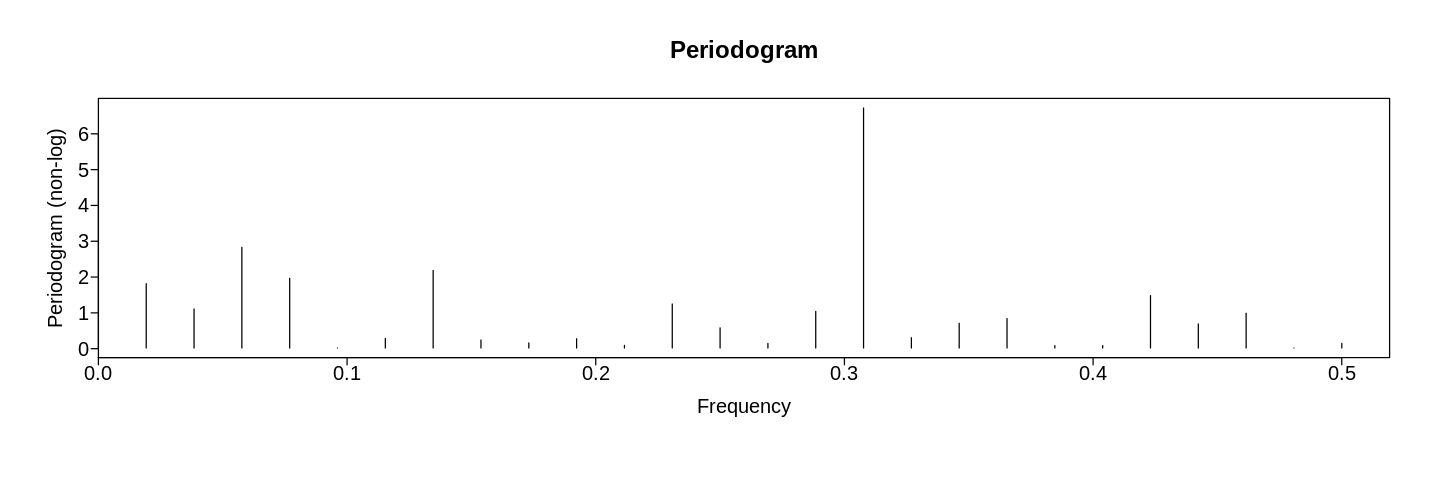

###Kerala Autocorrelation Plot and Periodogram

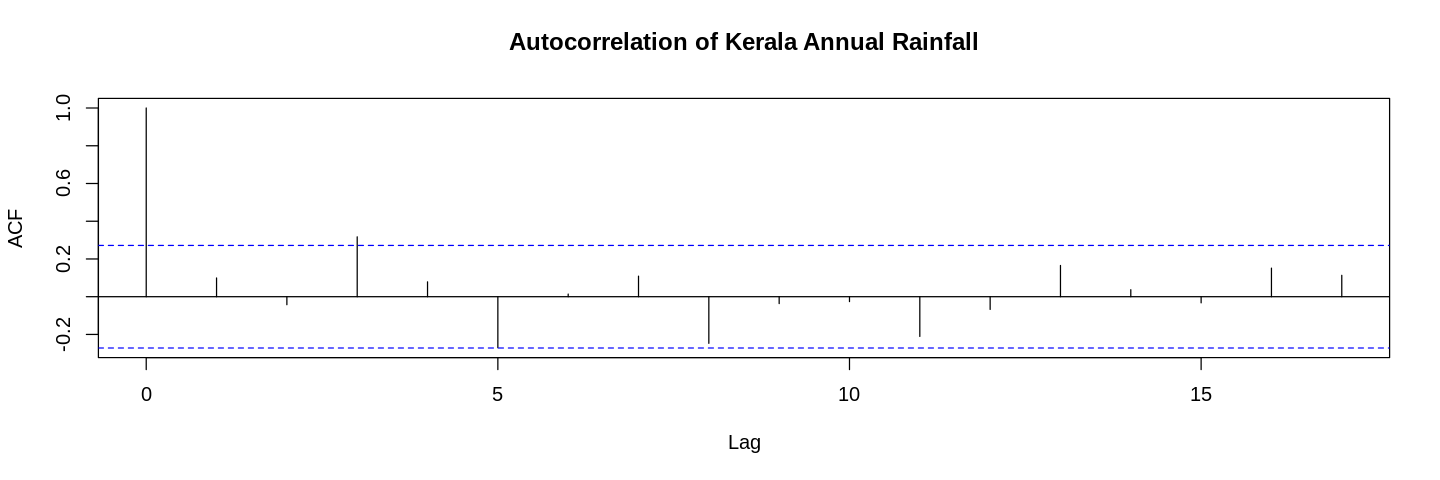

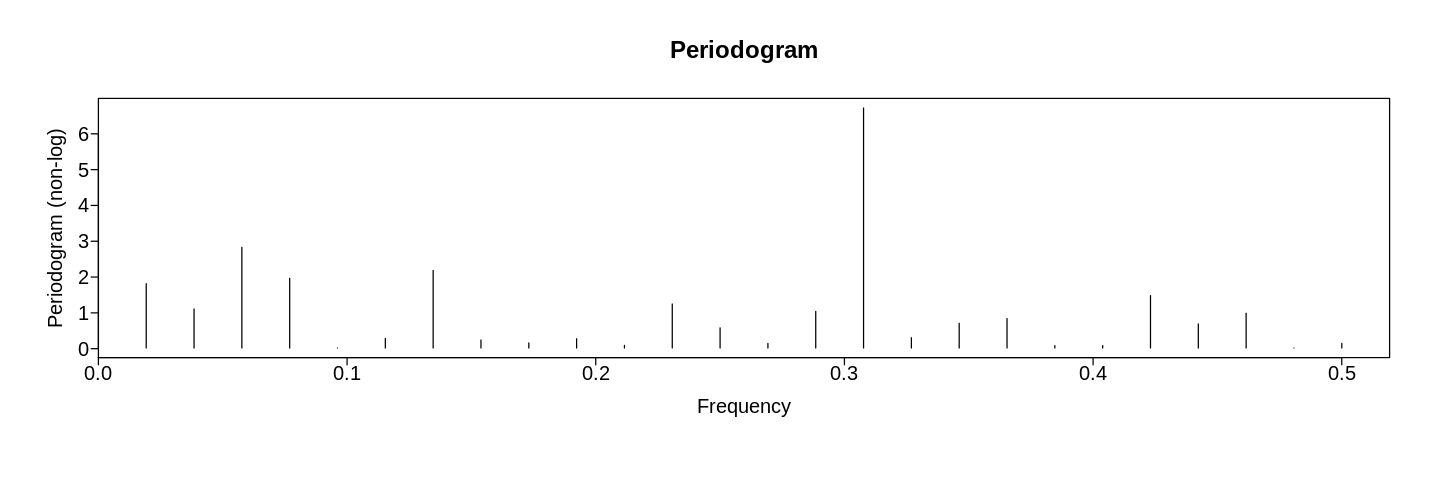

### El Nino Years

Based on the metrics provided in the paper, these are the El Nino years I found by subsetting the dataframe to match the requirements. Further categorization into stronger and weaker El Nino years can be found in the section titled "Deriving El Nino Years"



*   1958
*   1959
*   1964
*   1966
*   1969
*   1973
*   1977
*   1978
*   1980
*   1983 
*   1987
*   1988
*   1992
*   1995
*   1998
*   2003
*   2007
*   2010  
*   2016  






## Conclusions


---

**Q. What did you do?**

I investigated the data used in the original publication using tools we covered in Block 1. The language used was R, and the overall topics that aided my analysis were time domain analysis, frequency domain analysis, autocorrelation, autocovariance, and plotting in R. I was able to gather meaningful results to visualize how El Nino impacts people around the world.  


**Q. How did the tools that you used work?**

I was able to access a few useful functions from the textbook to facilitate my frequency domain analysis: the periodogram function and the Parzen window function. The periodogram utilized a Fourier transform in order to move from the time domain to the frequency domain. For plotting, I used the standard plot function in R but had to get a little more creative to get the plots to have the right aspect ratio and titles. I wrote my own functions for repeated analysis with different datasets to supplement the built-in R functions and those from the textbook

**Q. Were you able to find any patterns in the data?**

The major pattern I found in the data is periodic behavior for both the ENSO indices and for the PAD rates normalized per 1000 people. I also found that the two ENSO indices are very similar to each other when I was trying to derive the years that an El Nino event occurred. Finally, I found patterns between PAD data, ENSO indices, and the new Kerala annual precipitation dataset that I brought in.

##Discussion


---
**Q. What challenges did you run into (if any) and how did you overcome them?**

The multiple different kinds of missing data in R-- null type, NA, empty vector, etc.--was a challenge. I standardized the missing data to NA so it would be identifiable when filtering it out. When calculating the PAD rate per 1000, the issue of missing data recurred. I decided to calculate the total affected only for data points that have an associated population value. I also calculated the total unique population only with data points that had an associated 'Total Affected' number. I decided that creating my sums this way was the most appropriate way to address the missing data.
 
Figuring out the correct methodology and series of steps to calculate the PAD rate per 1000 initially produced numbers that were off by a factor of 10 when I calculated the PAD rates per year. I had to reorient my code to create sums for the total affected and for the total unique populations. 
 
To do a deeper investigation of the datasets, I settled on using the full-time range available because the analysis I was performing stretched further than the confines of the original publication. I was able to determine that none of the three plots showed signs of having aperiodicity and instead showed dominant frequencies that suggest a few potential periods. 
 
I had to also decide how I wanted to find the dominant frequencies of the El Nino years and eventually settled on classifying El Nino years as true and non-El Nino years as false. In order to get my plots to work, I had to cast the true/false values to integers so I ended up with a binary classification system with which to plot. From there, I switched to frequency domain analysis with a periodogram.
 
 

##References


---
El Niño information. (n.d.). Retrieved March 06, 2021, from https://wildlife.ca.gov/Conservation/Marine/El-Nino#:~:text=How%20often%20does%20El%20Niño,fall%20of%20the%20following%20year



Lam, H. C., Haines, A., McGregor, G., Chan, E. Y., & Hajat, S. (2019). Time-Series study of associations between rates of people affected by disasters and the El Niño Southern OSCILLATION (ENSO) CYCLE. International Journal of Environmental Research and Public Health, 16(17), 3146. doi:10.3390/ijerph16173146



Ilangovan, R. (2017, July 26). Rainfall in India - dataset By rajanand. Retrieved March 06, 2021, from https://data.world/rajanand/rainfall-in-india/


